In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python

import io # Input/Output Module
import os # OS interfaces
import cv2 # OpenCV package
import numpy as np # linear algebra
import keras
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from urllib import request # module for opening HTTP requests
from matplotlib import pyplot as plt # Plotting library

#Extra libraries for hog and pca
from skimage.io import imread
from skimage.transform import resize
from skimage.feature import hog
from skimage import exposure
from skimage import data
from skimage.color import (rgb2gray)

import time
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns
from IPython.display import clear_output

Using TensorFlow backend.


<div style="width:100%; height:140px">
    <img src="https://www.kuleuven.be/internationaal/thinktank/fotos-en-logos/ku-leuven-logo.png/image_preview" width = 300px, heigh = auto align=left>
</div>


KUL H02A5a Computer Vision: Group Assignment 1
---------------------------------------------------------------
Student numbers: <span style="color:red">r0703889, r0909802, r0716758, r0916443, r0822692</span>.

The goal of this assignment is to explore more advanced techniques for constructing features that better describe objects of interest and to perform face recognition using these features. This assignment will be delivered in groups of 5 (either composed by you or randomly assigned by your TA's).

In this assignment you are a group of computer vision experts that have been invited to ECCV 2021 to do a tutorial about  "Feature representations, then and now". To prepare the tutorial you are asked to participate in a kaggle competition and to release a notebook that can be easily studied by the tutorial participants. Your target audience is: (master) students who want to get a first hands-on introduction to the techniques that you apply.

---------------------------------------------------------------
This notebook is structured as follows:
0. Data loading & Preprocessing
1. Feature Representations
2. Evaluation Metrics 
3. Classifiers
4. Experiments
5. Publishing best results
6. Discussion

Make sure that your notebook is **self-contained** and **fully documented**. Walk us through all steps of your code. Treat your notebook as a tutorial for students who need to get a first hands-on introduction to the techniques that you apply. Provide strong arguments for the design choices that you made and what insights you got from your experiments. Make use of the *Group assignment* forum/discussion board on Toledo if you have any questions.

Fill in your student numbers above and get to it! Good luck! 


<div class="alert alert-block alert-info">
<b>NOTE:</b> This notebook is just a example/template, feel free to adjust in any way you please! Just keep things organised and document accordingly!
</div>

<div class="alert alert-block alert-info">
<b>NOTE:</b> Clearly indicate the improvements that you make!!! You can for instance use titles like: <i>3.1. Improvement: Non-linear SVM with RBF Kernel.<i>
</div>
    
---------------------------------------------------------------
# 0. Data loading & Preprocessing

## 0.1. Loading data
The training set is many times smaller than the test set and this might strike you as odd, however, this is close to a real world scenario where your system might be put through daily use! In this session we will try to do the best we can with the data that we've got! 

In [2]:
#os.listdir('/kaggle/input/computer-vision-assignment/kul-h02a5a-computer-vision-ga1-2022')
os.listdir('../cv_assignment1')

['.DS_Store',
 '.git',
 '.ipynb_checkpoints',
 'assets',
 'assignment1_v2.py',
 'group23-notebook.ipynb',
 'Notebook_clean_up.ipynb',
 'outpy.avi',
 'README.md',
 'test',
 'test_set.csv',
 'train',
 'train_set.csv',
 '_set.csv']

In [3]:
# Input data files are available in the read-only "../input/" directory

#train = pd.read_csv(
#    '/kaggle/input/computer-vision-assignment/kul-h02a5a-computer-vision-ga1-2022/train_set.csv', index_col = 0)
#train.index = train.index.rename('id')

#test = pd.read_csv(
#    '/kaggle/input/computer-vision-assignment/kul-h02a5a-computer-vision-ga1-2022/test_set.csv', index_col = 0)
#test.index = test.index.rename('id')

# read the images as numpy arrays and store in "img" column
#train['img'] = [cv2.cvtColor(np.load('/kaggle/input/computer-vision-assignment/kul-h02a5a-computer-vision-ga1-2022/train/train_{}.npy'.format(index), allow_pickle=False), cv2.COLOR_BGR2RGB) 
#                for index, row in train.iterrows()]

#test['img'] = [cv2.cvtColor(np.load('/kaggle/input/computer-vision-assignment/kul-h02a5a-computer-vision-ga1-2022/test/test_{}.npy'.format(index), allow_pickle=False), cv2.COLOR_BGR2RGB) 
#                for index, row in test.iterrows()]
  

#train_size, test_size = len(train),len(test)

#"The training set contains {} examples, the test set contains {} examples.".format(train_size, test_size)

In [4]:
# Input data files are available in the read-only "../input/" directory

train = pd.read_csv(
    'train_set.csv', index_col = 0)
train.index = train.index.rename('id')

test = pd.read_csv(
    'test_set.csv', index_col = 0)
test.index = test.index.rename('id')

# read the images as numpy arrays and store in "img" column
train['img'] = [cv2.cvtColor(np.load('train/train_{}.npy'.format(index), allow_pickle=False), cv2.COLOR_BGR2RGB) 
                for index, row in train.iterrows()]

test['img'] = [cv2.cvtColor(np.load('test/test_{}.npy'.format(index), allow_pickle=False), cv2.COLOR_BGR2RGB) 
                for index, row in test.iterrows()]
  

train_size, test_size = len(train),len(test)

"The training set contains {} examples, the test set contains {} examples.".format(train_size, test_size)

'The training set contains 80 examples, the test set contains 1816 examples.'

*Note: this dataset is a subset of the* [*VGG face dataset*](https://www.robots.ox.ac.uk/~vgg/data/vgg_face/).

## 0.2. A first look
Let's have a look at the data columns and class distribution.

In [5]:
# The training set contains an identifier, name, image information and class label
train.head()

name  class                                                img
id                                                                        
0     Mila_Kunis      2  [[[50, 31, 25], [49, 30, 24], [49, 30, 24], [4...
1     Mila_Kunis      2  [[[24, 35, 31], [25, 36, 32], [27, 36, 33], [2...
2   Michael_Cera      0  [[[111, 112, 106], [111, 112, 106], [112, 113,...
3     Mila_Kunis      2  [[[223, 223, 223], [223, 223, 223], [223, 223,...
4   Michael_Cera      0  [[[195, 195, 205], [195, 195, 205], [190, 192,...

In [6]:
# The test set only contains an identifier and corresponding image information.

test.head(1)

img
id                                                   
0   [[[209, 210, 205], [208, 209, 204], [208, 209,...

In [7]:
# The class distribution in the training set:
train.groupby('name').agg({'img':'count', 'class': 'max'})

img  class
name                       
Jesse_Eisenberg   30      1
Michael_Cera      10      0
Mila_Kunis        30      2
Sarah_Hyland      10      0

Note that **Jesse is assigned the classification label 1**, and **Mila is assigned the classification label 2**. The dataset also contains 20 images of **look alikes (assigned classification label 0)** and the raw images. 

## 0.3. Preprocess data
### 0.3.1 Example: HAAR face detector
In this example we use the [HAAR feature based cascade classifiers](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_objdetect/py_face_detection/py_face_detection.html) to detect faces, then the faces are resized so that they all have the same shape. If there are multiple faces in an image, we only take the first one. 

<div class="alert alert-block alert-info"> <b>NOTE:</b> You can write temporary files to <code>/kaggle/temp/</code> or <code>../../tmp</code>, but they won't be saved outside of the current session
</div>


In [8]:
class HAARPreprocessor():
    """Preprocessing pipeline built around HAAR feature based cascade classifiers. """
    
    def __init__(self, path, face_size):
        self.face_size = face_size
        file_path = os.path.join(path, "haarcascade_frontalface_default.xml")
        if not os.path.exists(file_path): 
            if not os.path.exists(path):
                os.mkdir(path)
            self.download_model(file_path)
        
        self.classifier = cv2.CascadeClassifier(file_path)
  
    def download_model(self, path):
        url = "https://raw.githubusercontent.com/opencv/opencv/master/data/"\
            "haarcascades/haarcascade_frontalface_default.xml"
        
        with request.urlopen(url) as r, open(path, 'wb') as f:
            f.write(r.read())
            
    def detect_faces(self, img):
        """Detect all faces in an image."""
        
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        return self.classifier.detectMultiScale(
            img_gray,
            scaleFactor=1.2,
            minNeighbors=7, #5
            minSize=(15, 15), #(30,30)
            flags=cv2.CASCADE_SCALE_IMAGE
        )
        
    def extract_faces(self, img):
        """Returns all faces (cropped) in an image."""
        
        faces = self.detect_faces(img)

        return [img[y:y+h, x:x+w] for (x, y, w, h) in faces]
    
    def preprocess(self, data_row):
        faces = self.extract_faces(data_row['img'])
        
        # if no faces were found, return None
        if len(faces) == 0:
            nan_img = np.empty(self.face_size + (3,))
            nan_img[:] = np.nan
            return nan_img
        
        # only return the first face
        return cv2.resize(faces[0], self.face_size, interpolation = cv2.INTER_AREA)
            
    def __call__(self, data):
        return np.stack([self.preprocess(row) for _, row in data.iterrows()]).astype(int)

**Visualise**

Let's plot a few examples.

In [9]:
# parameter to play with 
# Set to 80x80 for the HOG feature extractor
FACE_SIZE = (80, 80)

def plot_image_sequence(data, n, imgs_per_row=7):
    n_rows = 1 + int(n/(imgs_per_row+1))
    n_cols = min(imgs_per_row, n)

    f,ax = plt.subplots(n_rows,n_cols, figsize=(10*n_cols,10*n_rows))
    for i in range(n):
        if n == 1:
            ax.imshow(data[i])
        elif n_rows > 1:
            ax[int(i/imgs_per_row),int(i%imgs_per_row)].imshow(data[i])
        else:
            ax[int(i%n)].imshow(data[i])
    plt.show()

    
#preprocessed data 
preprocessor = HAARPreprocessor(path = '../../tmp', face_size=FACE_SIZE)

train_X, train_y = preprocessor(train), train['class'].values
test_X = preprocessor(test)



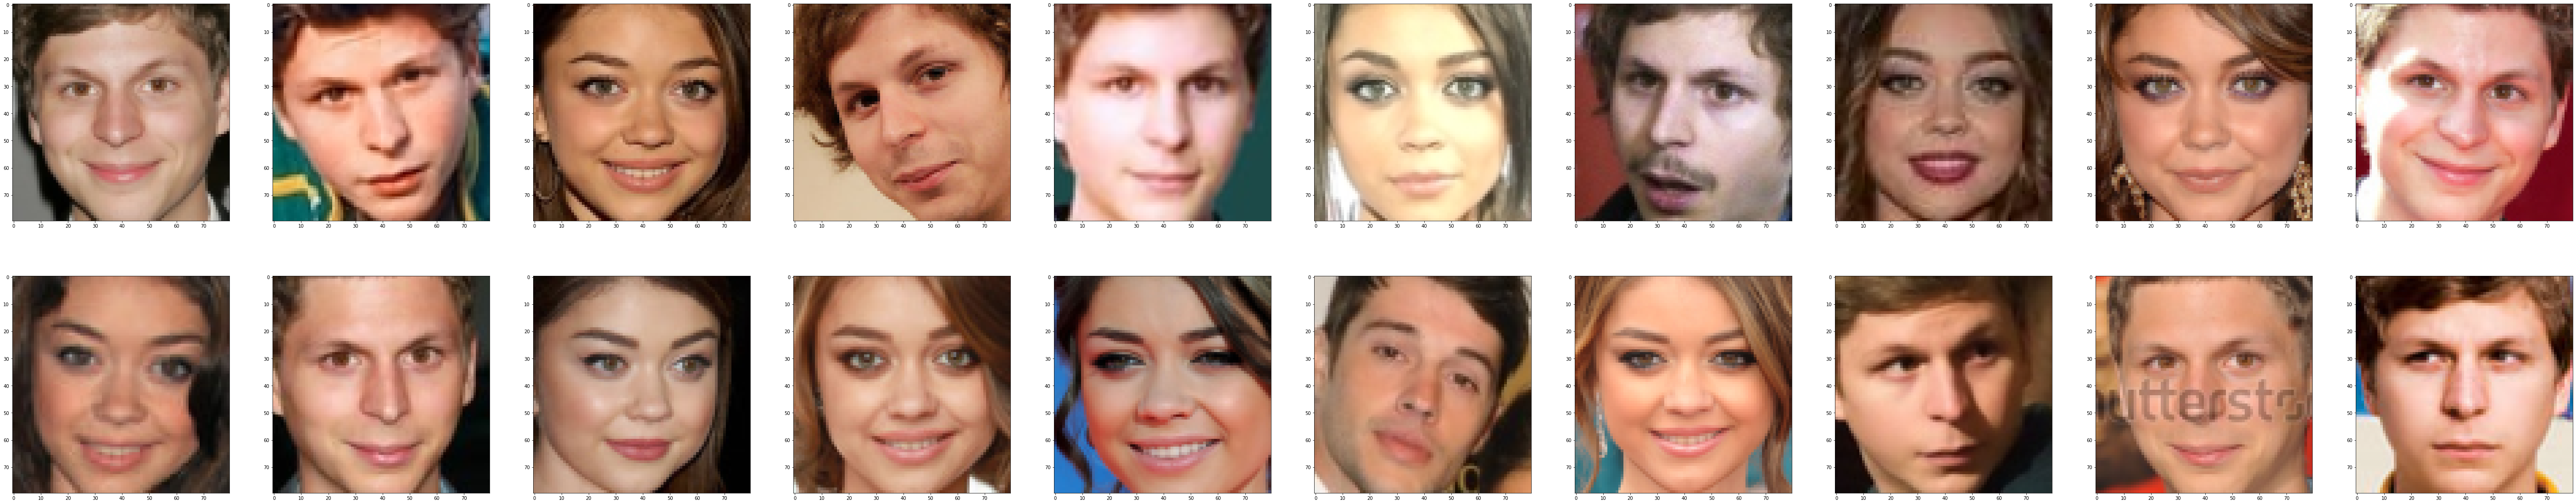

In [10]:
# plot faces of Michael and Sarah

plot_image_sequence(train_X[train_y == 0], n=20, imgs_per_row=10)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


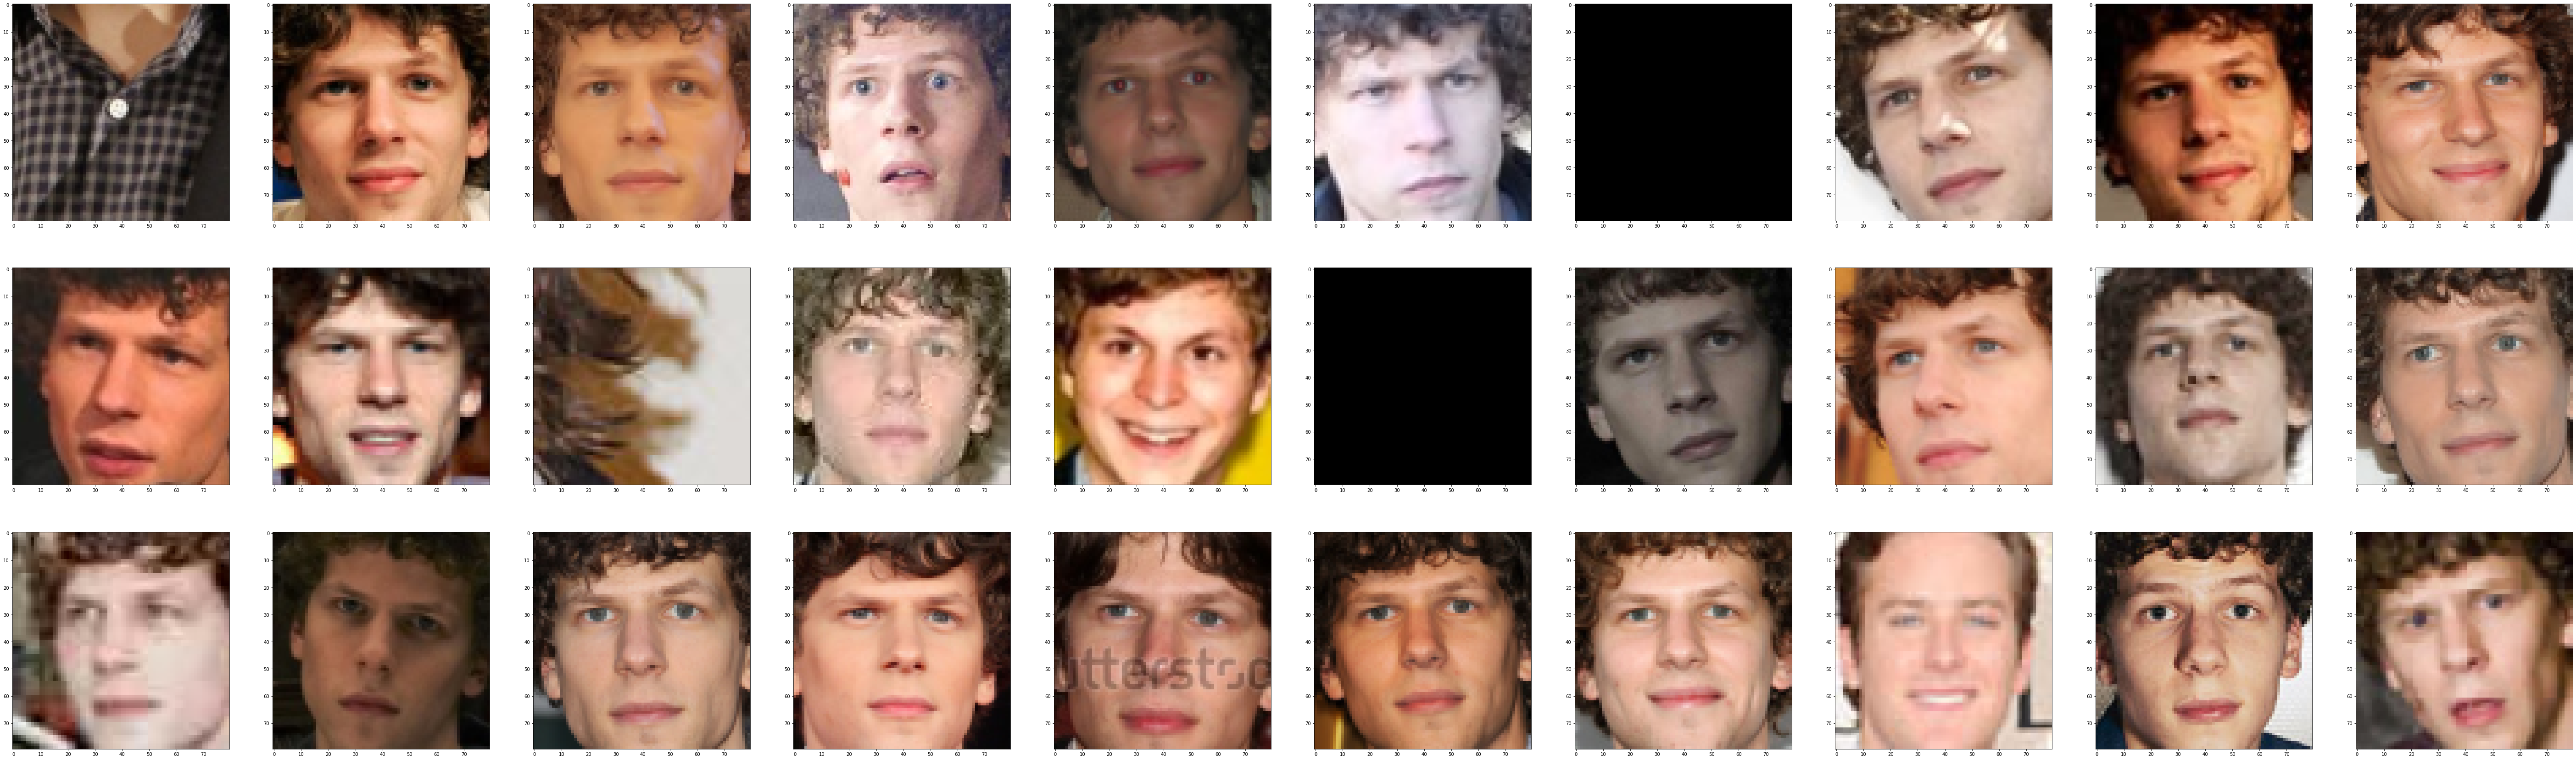

In [11]:
# plot faces of Jesse

plot_image_sequence(train_X[train_y == 1], n=30, imgs_per_row=10)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


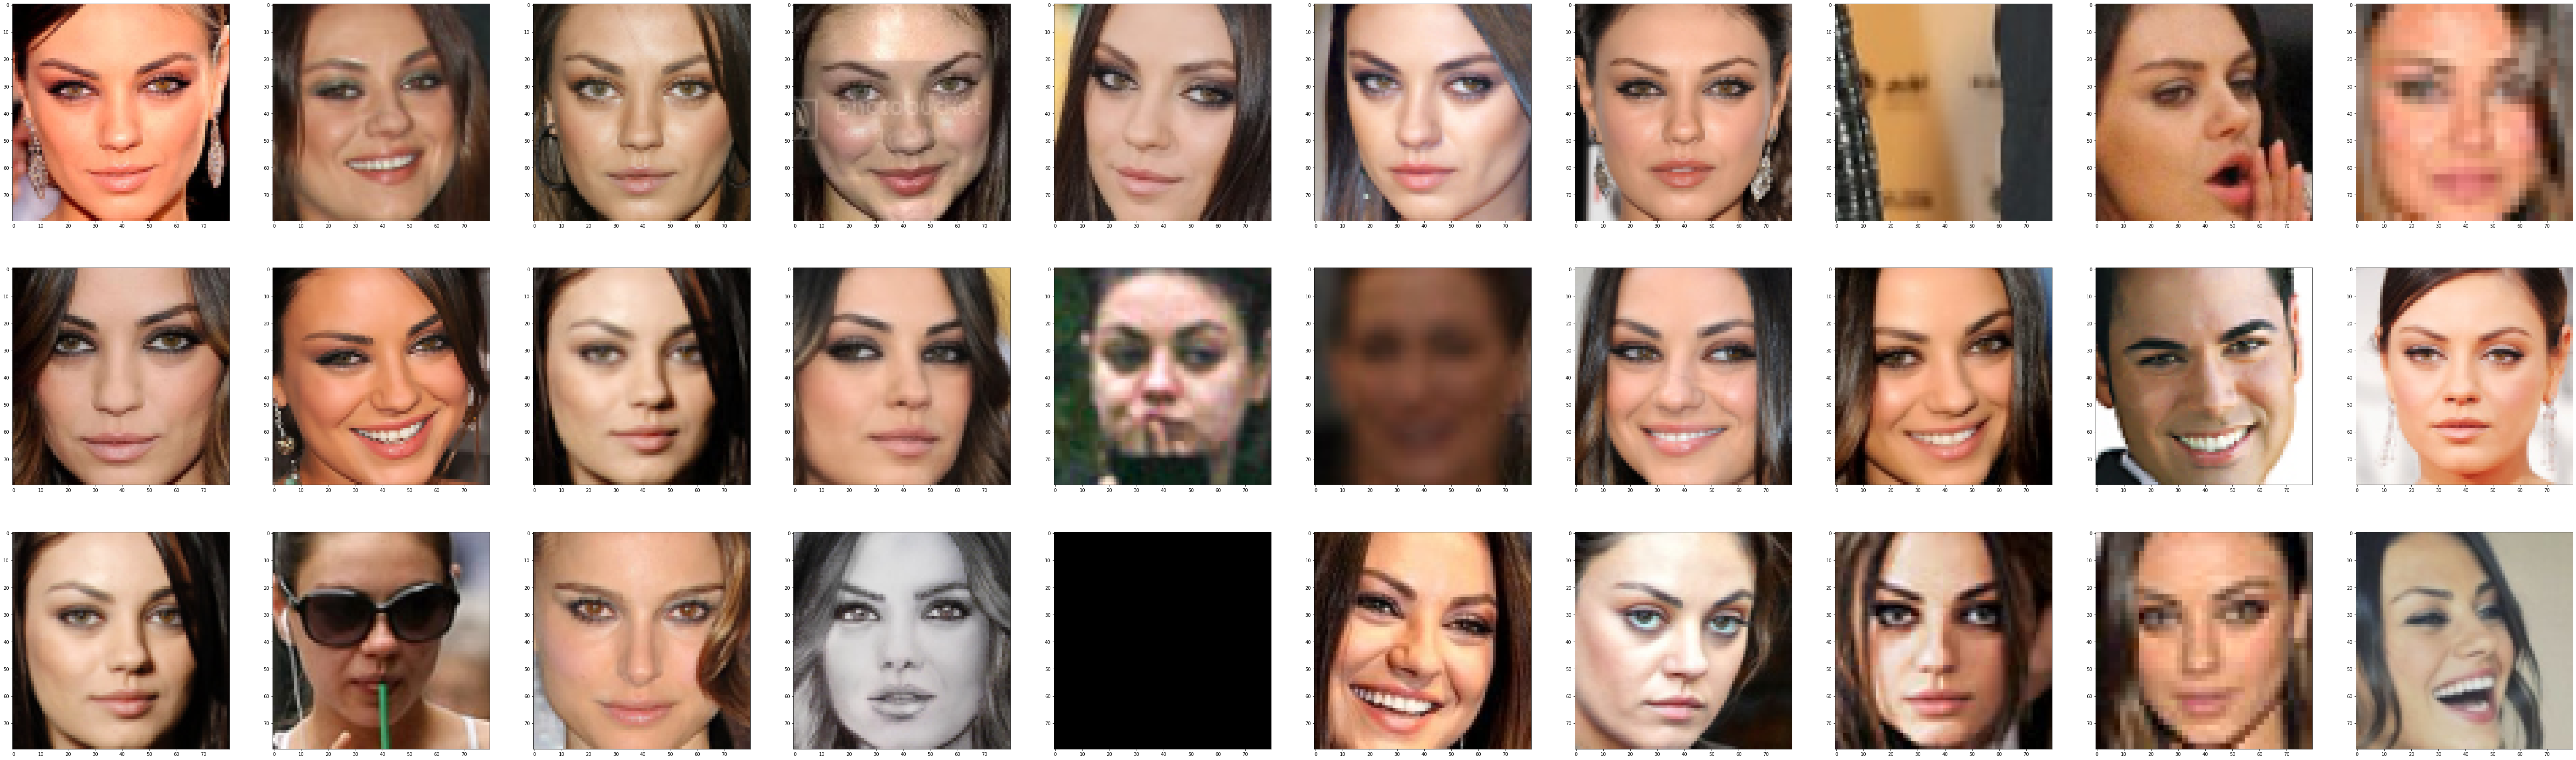

In [12]:
# plot faces of Mila

plot_image_sequence(train_X[train_y == 2], n=30, imgs_per_row=10)

## Data augmentation using prior knowledge
We can use the prior knowledge of this data set to generate new examples from the existing data set. These are the so called virtual examples. In this case we have to classify images of faces in three groups. Therefore if we for example mirror the images of the faces, they should remain in the same class. Using this method we can augment the data set with virtual examples.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


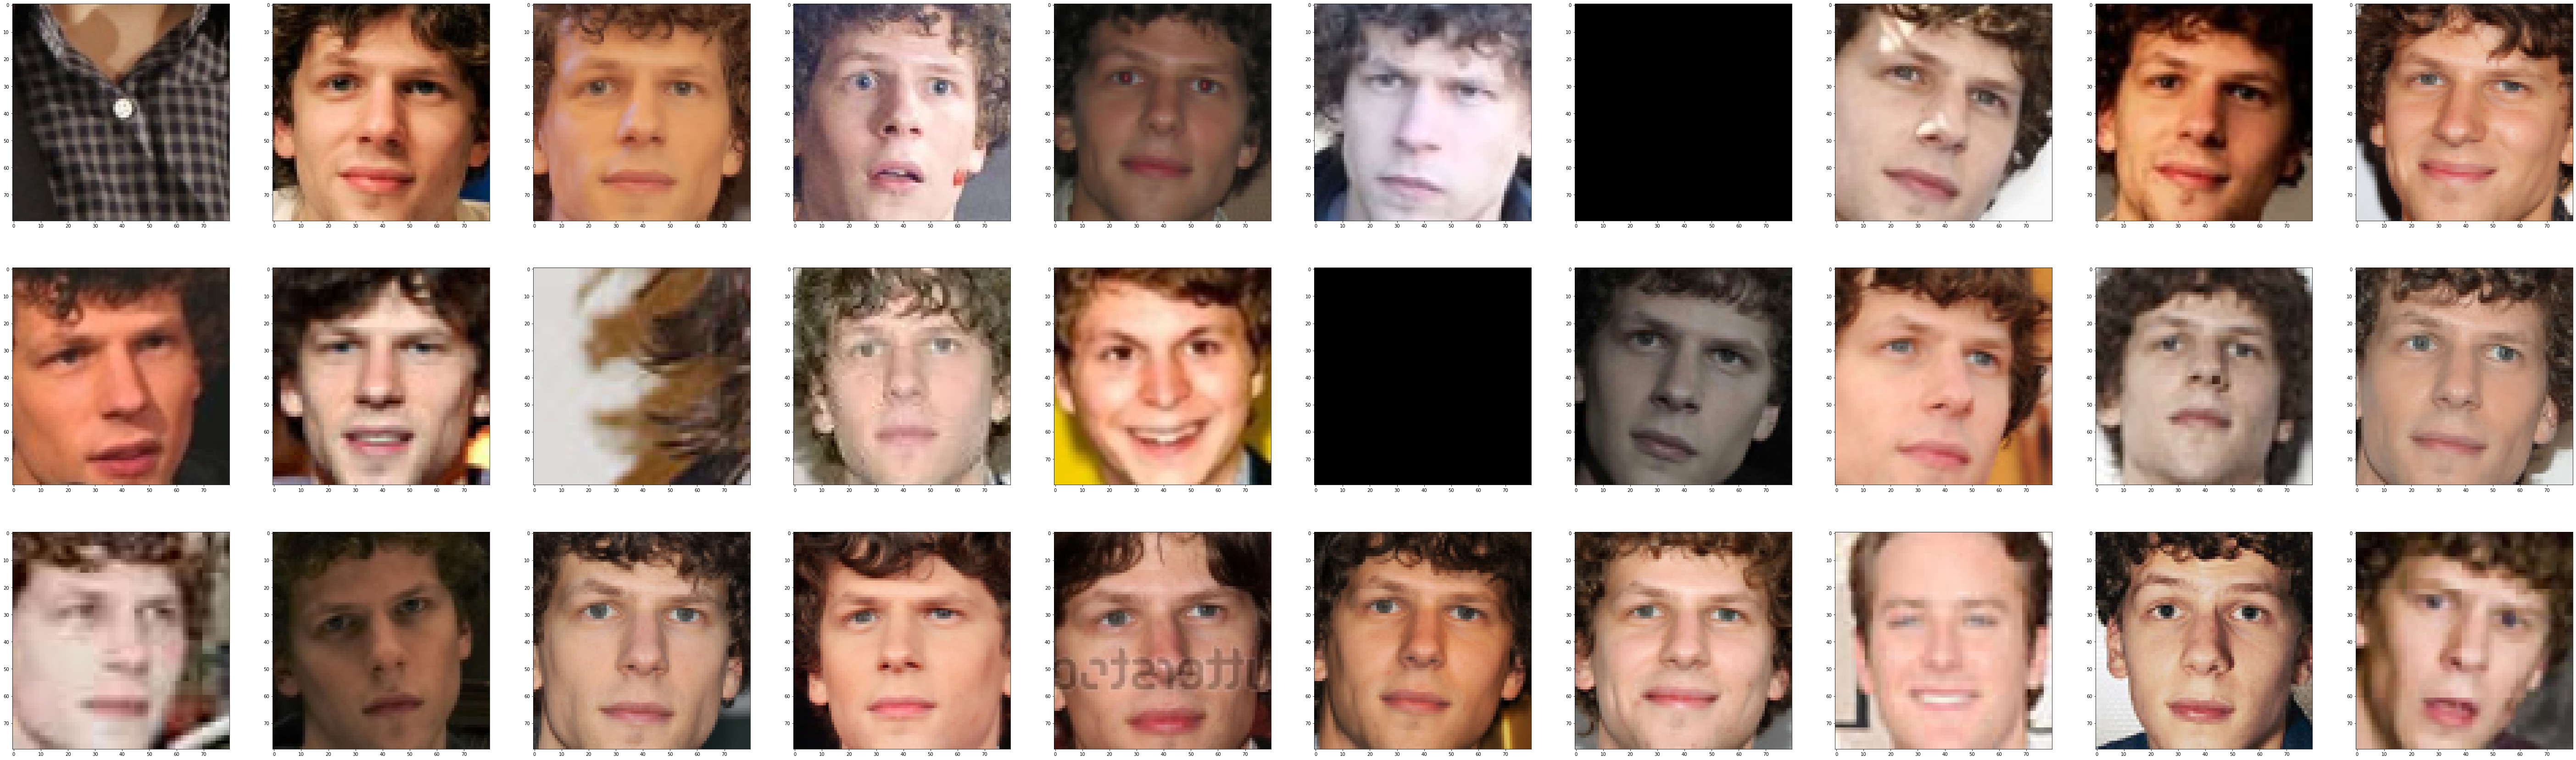

In [13]:
# mirroring examples Jesse
trainingExamplesJesse = train_X[train_y == 1]
n = 30
imgs_per_row = 10
n_rows = 1 + int(n/(imgs_per_row+1))
n_cols = min(imgs_per_row, n)
list_img_mirr = []
        
# creating mirror images
f,ax = plt.subplots(n_rows,n_cols, figsize=(10*n_cols,10*n_rows))

for i in range(n):
    img = trainingExamplesJesse[i]
    mirrored = np.fliplr(img)

    list_img_mirr.append(mirrored)

    if n == 1:
        ax.imshow(list_img_mirr[i])
    elif n_rows > 1:
        ax[int(i/imgs_per_row),int(i%imgs_per_row)].imshow(list_img_mirr[i])
    else:
        ax[int(i%n)].imshow(list_img_mirr[i])

plt.show()  

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


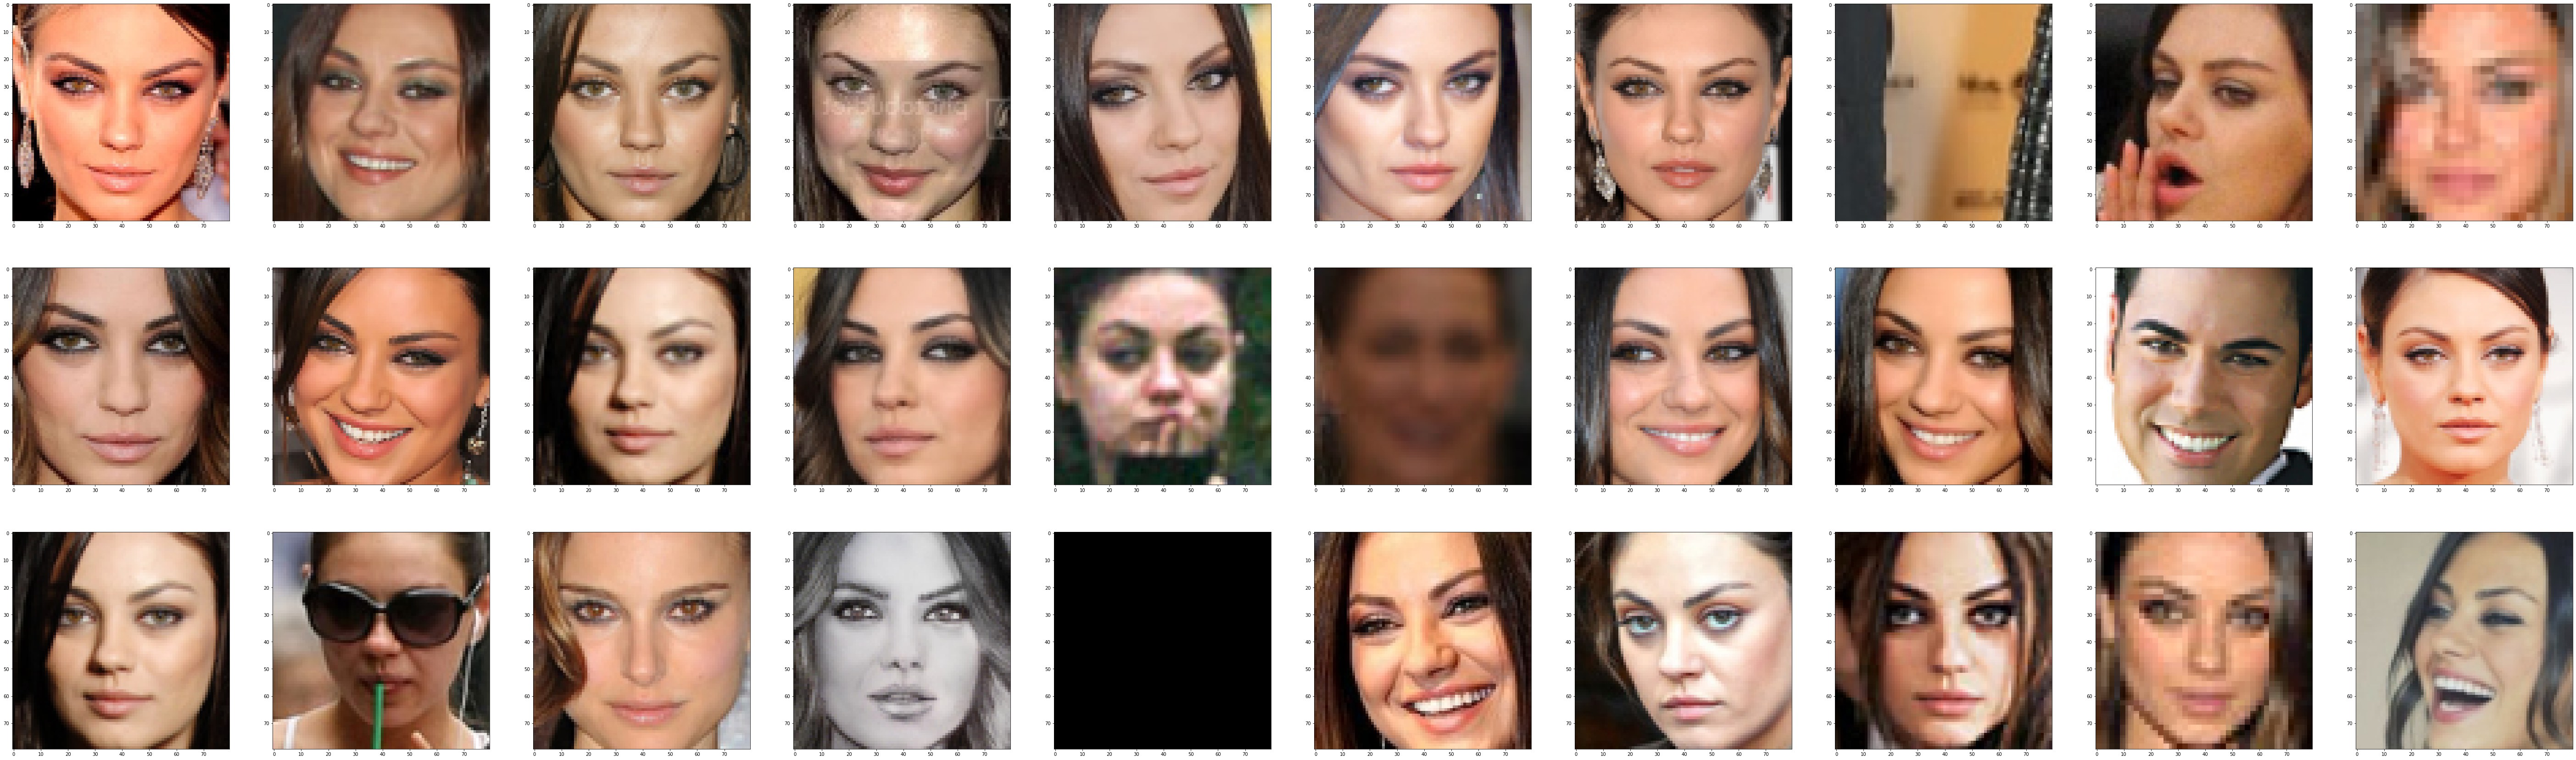

In [14]:
# mirroring examples Mila
trainingExamplesMila = train_X[train_y == 2]
n = 30
imgs_per_row = 10
n_rows = 1 + int(n/(imgs_per_row+1))
n_cols = min(imgs_per_row, n)
        
# creating mirror images
f,ax = plt.subplots(n_rows,n_cols, figsize=(10*n_cols,10*n_rows))

for i in range(n):
    img = trainingExamplesMila[i]
    mirrored = np.fliplr(img)

    list_img_mirr.append(mirrored)

    if n == 1:
        ax.imshow(list_img_mirr[30+i])
    elif n_rows > 1:
        ax[int(i/imgs_per_row),int(i%imgs_per_row)].imshow(list_img_mirr[30+i])
    else:
        ax[int(i%n)].imshow(list_img_mirr[30+i])

plt.show()  

In [15]:
# removing unnecessary images
list_img_mirr.pop(0)
list_img_mirr.pop(5)
list_img_mirr.pop(10)
list_img_mirr.pop(12)
list_img_mirr.pop(33)
list_img_mirr.pop(49)

array([[[-2147483648, -2147483648, -2147483648],
        [-2147483648, -2147483648, -2147483648],
        [-2147483648, -2147483648, -2147483648],
        ...,
        [-2147483648, -2147483648, -2147483648],
        [-2147483648, -2147483648, -2147483648],
        [-2147483648, -2147483648, -2147483648]],

       [[-2147483648, -2147483648, -2147483648],
        [-2147483648, -2147483648, -2147483648],
        [-2147483648, -2147483648, -2147483648],
        ...,
        [-2147483648, -2147483648, -2147483648],
        [-2147483648, -2147483648, -2147483648],
        [-2147483648, -2147483648, -2147483648]],

       [[-2147483648, -2147483648, -2147483648],
        [-2147483648, -2147483648, -2147483648],
        [-2147483648, -2147483648, -2147483648],
        ...,
        [-2147483648, -2147483648, -2147483648],
        [-2147483648, -2147483648, -2147483648],
        [-2147483648, -2147483648, -2147483648]],

       ...,

       [[-2147483648, -2147483648, -2147483648],
        [-2

In [16]:
print(len(list_img_mirr))

54


In [17]:
print(len(train_X))
newTrain_X = np.append(train_X, list_img_mirr, axis = 0)
print(len(newTrain_X))

80
134


In [18]:
ones = np.repeat(1, 26)
twos = np.repeat(2,28)
newTrain_y = np.append(train_y, ones)
newTrain_y = np.append(newTrain_y, twos)
print(len(newTrain_y))

134


A second way to virtually augment the data, is by reducing the quality of the data. We can for example blur the images. This way of augmenting the data set works better than the mirroring technique. 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


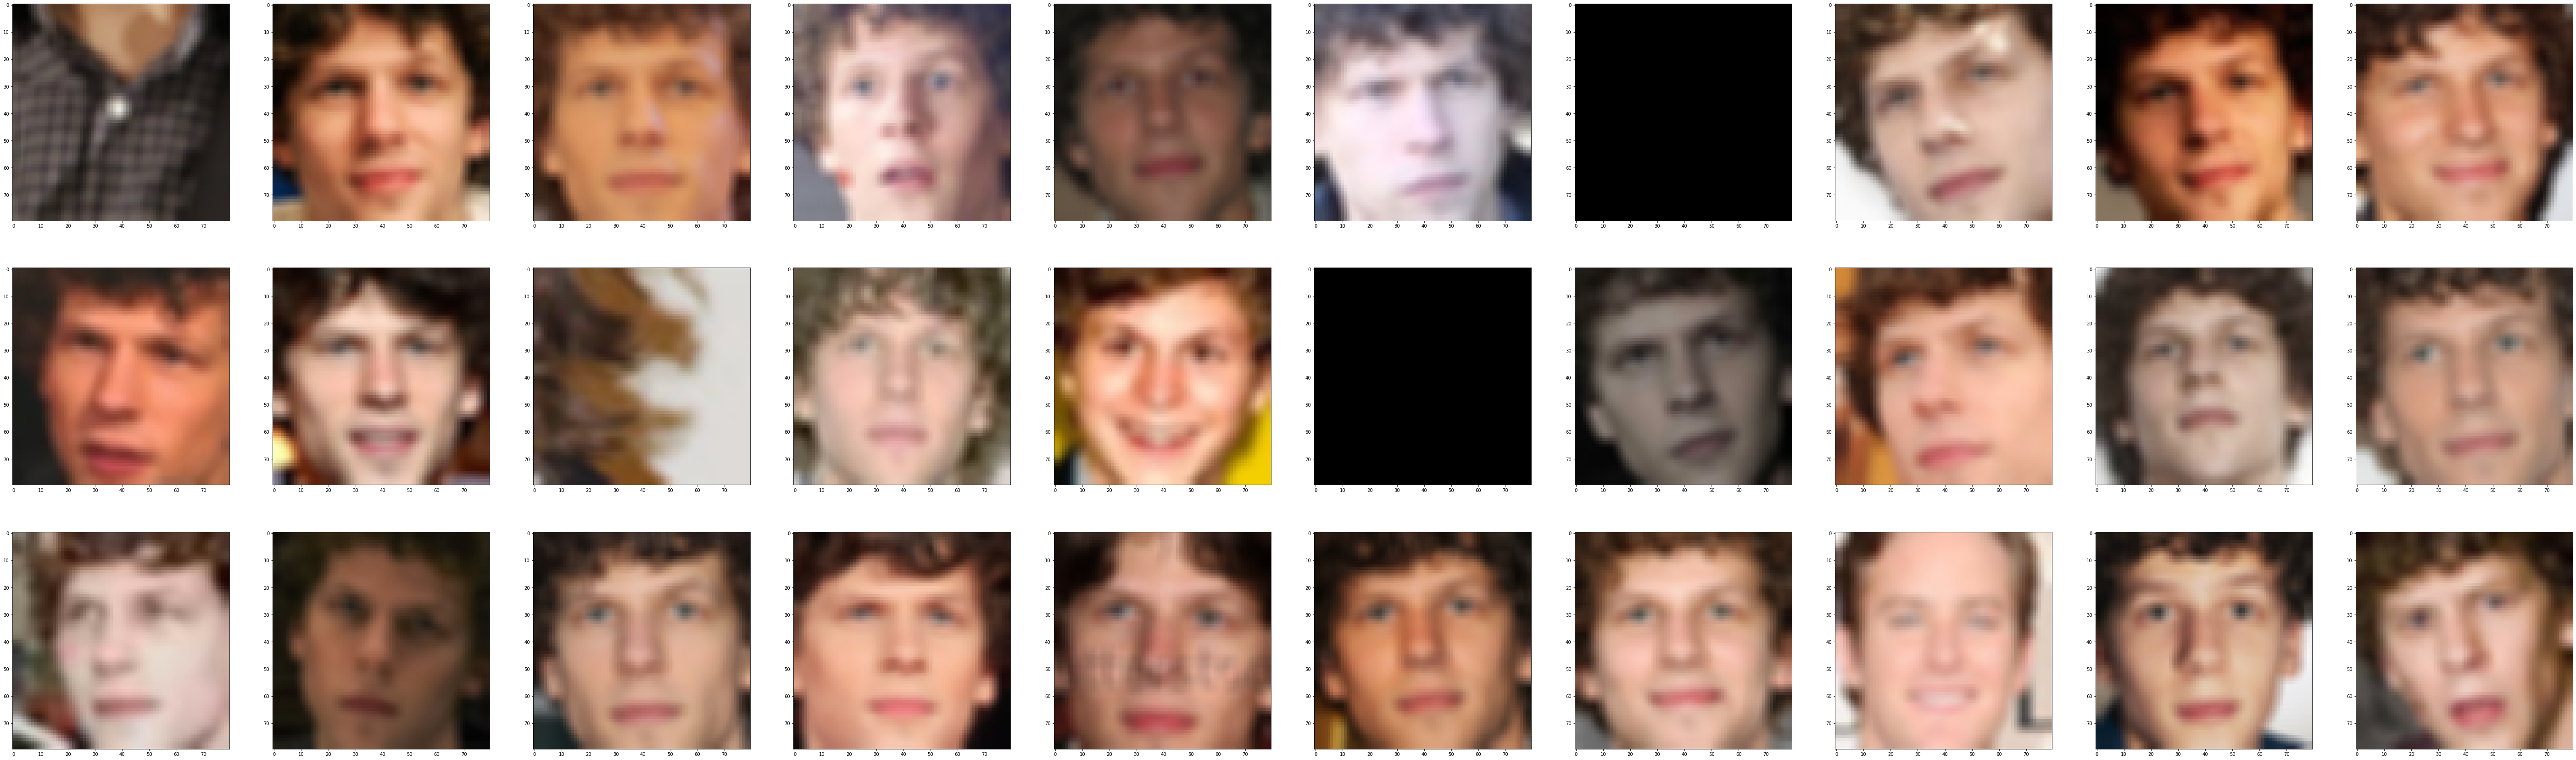

In [19]:
# blurring examples Jesse
trainingExamplesJesse = train_X[train_y == 1]
n = 30
imgs_per_row = 10
n_rows = 1 + int(n/(imgs_per_row+1))
n_cols = min(imgs_per_row, n)
list_img_blurred = []
        
# creating mirror images
f,ax = plt.subplots(n_rows,n_cols, figsize=(10*n_cols,10*n_rows))

for i in range(n):
    img = trainingExamplesJesse[i]
    blurred = cv2.blur(img, (5,5))

    list_img_blurred.append(blurred)

    if n == 1:
        ax.imshow(list_img_blurred[i])
    elif n_rows > 1:
        ax[int(i/imgs_per_row),int(i%imgs_per_row)].imshow(list_img_blurred[i])
    else:
        ax[int(i%n)].imshow(list_img_blurred[i])

plt.show()  

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


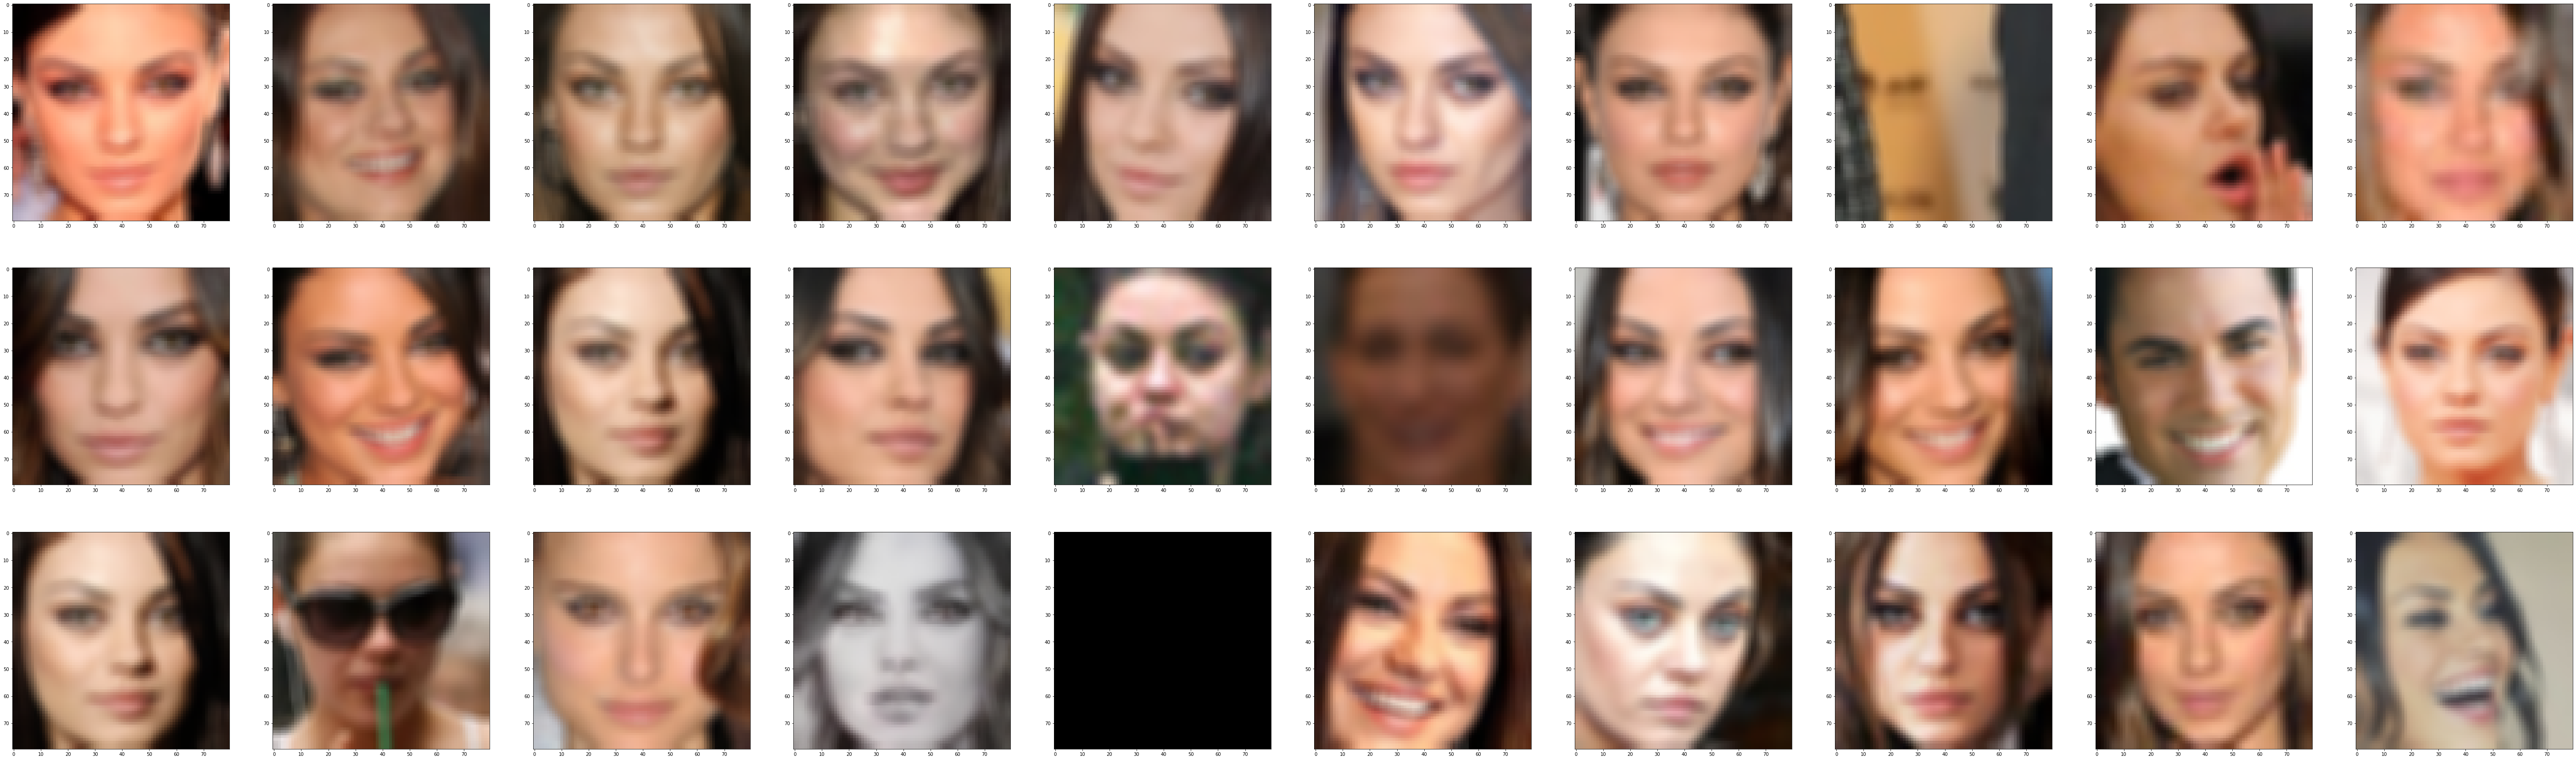

In [20]:
# blurring examples Mila
trainingExamplesMila = train_X[train_y == 2]
n = 30
imgs_per_row = 10
n_rows = 1 + int(n/(imgs_per_row+1))
n_cols = min(imgs_per_row, n)
        
# creating mirror images
f,ax = plt.subplots(n_rows,n_cols, figsize=(10*n_cols,10*n_rows))

for i in range(n):
    img = trainingExamplesMila[i]
    blurred = cv2.blur(img, (5,5))

    list_img_blurred.append(blurred)

    if n == 1:
        ax.imshow(list_img_blurred[30+i])
    elif n_rows > 1:
        ax[int(i/imgs_per_row),int(i%imgs_per_row)].imshow(list_img_blurred[30+i])
    else:
        ax[int(i%n)].imshow(list_img_blurred[30+i])

plt.show()  

In [21]:
# removing unnecessary images
list_img_blurred.pop(0)
list_img_blurred.pop(5)
list_img_blurred.pop(10)
list_img_blurred.pop(12)
list_img_blurred.pop(33)
list_img_blurred.pop(49)

array([[[-85899344, -85899344, -85899344],
        [-85899344, -85899344, -85899344],
        [-85899344, -85899344, -85899344],
        ...,
        [-85899344, -85899344, -85899344],
        [-85899344, -85899344, -85899344],
        [-85899344, -85899344, -85899344]],

       [[-85899344, -85899344, -85899344],
        [-85899344, -85899344, -85899344],
        [-85899344, -85899344, -85899344],
        ...,
        [-85899344, -85899344, -85899344],
        [-85899344, -85899344, -85899344],
        [-85899344, -85899344, -85899344]],

       [[-85899344, -85899344, -85899344],
        [-85899344, -85899344, -85899344],
        [-85899344, -85899344, -85899344],
        ...,
        [-85899344, -85899344, -85899344],
        [-85899344, -85899344, -85899344],
        [-85899344, -85899344, -85899344]],

       ...,

       [[-85899344, -85899344, -85899344],
        [-85899344, -85899344, -85899344],
        [-85899344, -85899344, -85899344],
        ...,
        [-85899344, -85899

In [22]:
print(len(train_X))
newTrain_X = np.append(train_X, list_img_blurred, axis = 0)
print(len(newTrain_X))

80
134


In [23]:
ones = np.repeat(1, 26)
twos = np.repeat(2,28)
newTrain_y = np.append(train_y, ones)
newTrain_y = np.append(newTrain_y, twos)
print(len(newTrain_y))

134


## 0.4. Store Preprocessed data (optional)
<div class="alert alert-block alert-info">
<b>NOTE:</b> You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All". Feel free to use this to store intermediary results.
</div>

In [24]:
# save preprocessed data
# prep_path = '/kaggle/working/prepped_data/'
# if not os.path.exists(prep_path):
#     os.mkdir(prep_path)
    
# np.save(os.path.join(prep_path, 'train_X.npy'), train_X)
# np.save(os.path.join(prep_path, 'train_y.npy'), train_y)
# np.save(os.path.join(prep_path, 'test_X.npy'), test_X)

# load preprocessed data
# prep_path = '/kaggle/working/prepped_data/'
# if not os.path.exists(prep_path):
#     os.mkdir(prep_path)
# train_X = np.load(os.path.join(prep_path, 'train_X.npy'))
# train_y = np.load(os.path.join(prep_path, 'train_y.npy'))
# test_X = np.load(os.path.join(prep_path, 'test_X.npy'))

Now we are ready to rock!

# 1. Feature Representations
## 1.0. Example: Identify feature extractor
Our example feature extractor doesn't actually do anything... It just returns the input:
$$
\forall x : f(x) = x.
$$

It does make for a good placeholder and baseclass ;).

In [25]:
class IdentityFeatureExtractor:
    """A simple function that returns the input"""
    
    def transform(self, X):
        return X
    
    def __call__(self, X):
        return self.transform(X)

## 1.1. Baseline 1: HOG feature extractor/Scale Invariant Feature Transform

HOG and SIFT are both very similar feature descriptors. 
However, the HOG feature extractor is used more frequently in classification problems than SIFT. The latter is used more in identificating specific objects. By this reason, we decided to implement the HOG feature extractor.


The HOG feature extractor counts occurences of gradient orientations in a localized portion of an image. The purpose of this technique to receive a better objects detection by focusing on the structure/shape of an object. This technique is widely used in computer vision and image processing, and was introducedin a research paper of Dala and Triggs in 2005.
This technique returns mostly sligtly better results than other edge descriptors because it also uses the magnitude and angle gradient to compute features, from which it generates an histogram.


In [26]:
class HOGFeatureExtractor(IdentityFeatureExtractor):
    """
    https://www.thepythoncode.com/article/hog-feature-extraction-in-python

    """
    
    def __init__(self, X):
        self.X = X
        

    def save_extract(self):
        """         
         Saves images converted by HOG extractor
         
         Returns
         -------
         list_img : Array of arrays representing the Hog_images
        """
        n = self.X.shape
        list_img = []
        
        for i in range(n[0]):
            img = self.X[i]
            converted = np.float32(img)
            gray = cv2.cvtColor(converted, cv2.COLOR_BGR2GRAY)
            blur = cv2.GaussianBlur(gray,(5,5),cv2.BORDER_DEFAULT) # Gaussian Filtering
            fd, hog_image = hog(blur, orientations=10, pixels_per_cell=(5, 5), cells_per_block=(2, 2), block_norm="L2", visualize=True)

            list_img.append(hog_image)
        
        return list_img

    def plot_extract(self):
        n = self.X.shape
        imgs_per_row = 10
        n_rows = 1 + int(n[0]/(imgs_per_row+1))
        n_cols = min(imgs_per_row, n[0])
        list_img = []
        
        # creating hog features
        f,ax = plt.subplots(n_rows,n_cols, figsize=(10*n_cols,10*n_rows))

        for i in range(n[0]):
            img = self.X[i]
            converted = np.float32(img)
            gray = cv2.cvtColor(converted, cv2.COLOR_BGR2GRAY)
            blur = cv2.GaussianBlur(gray,(5,5),cv2.BORDER_DEFAULT) # Gaussian Filtering
            fd, hog_image = hog(blur, orientations=10, pixels_per_cell=(5, 5), cells_per_block=(2, 2), block_norm="L2", visualize=True)    

            list_img.append(hog_image)

            if n[0] == 1:
                ax.imshow(list_img[i])
            elif n_rows > 1:
                ax[int(i/imgs_per_row),int(i%imgs_per_row)].imshow(list_img[i])
            else:
                ax[int(i%n[0])].imshow(list_img[i])

        plt.show()  


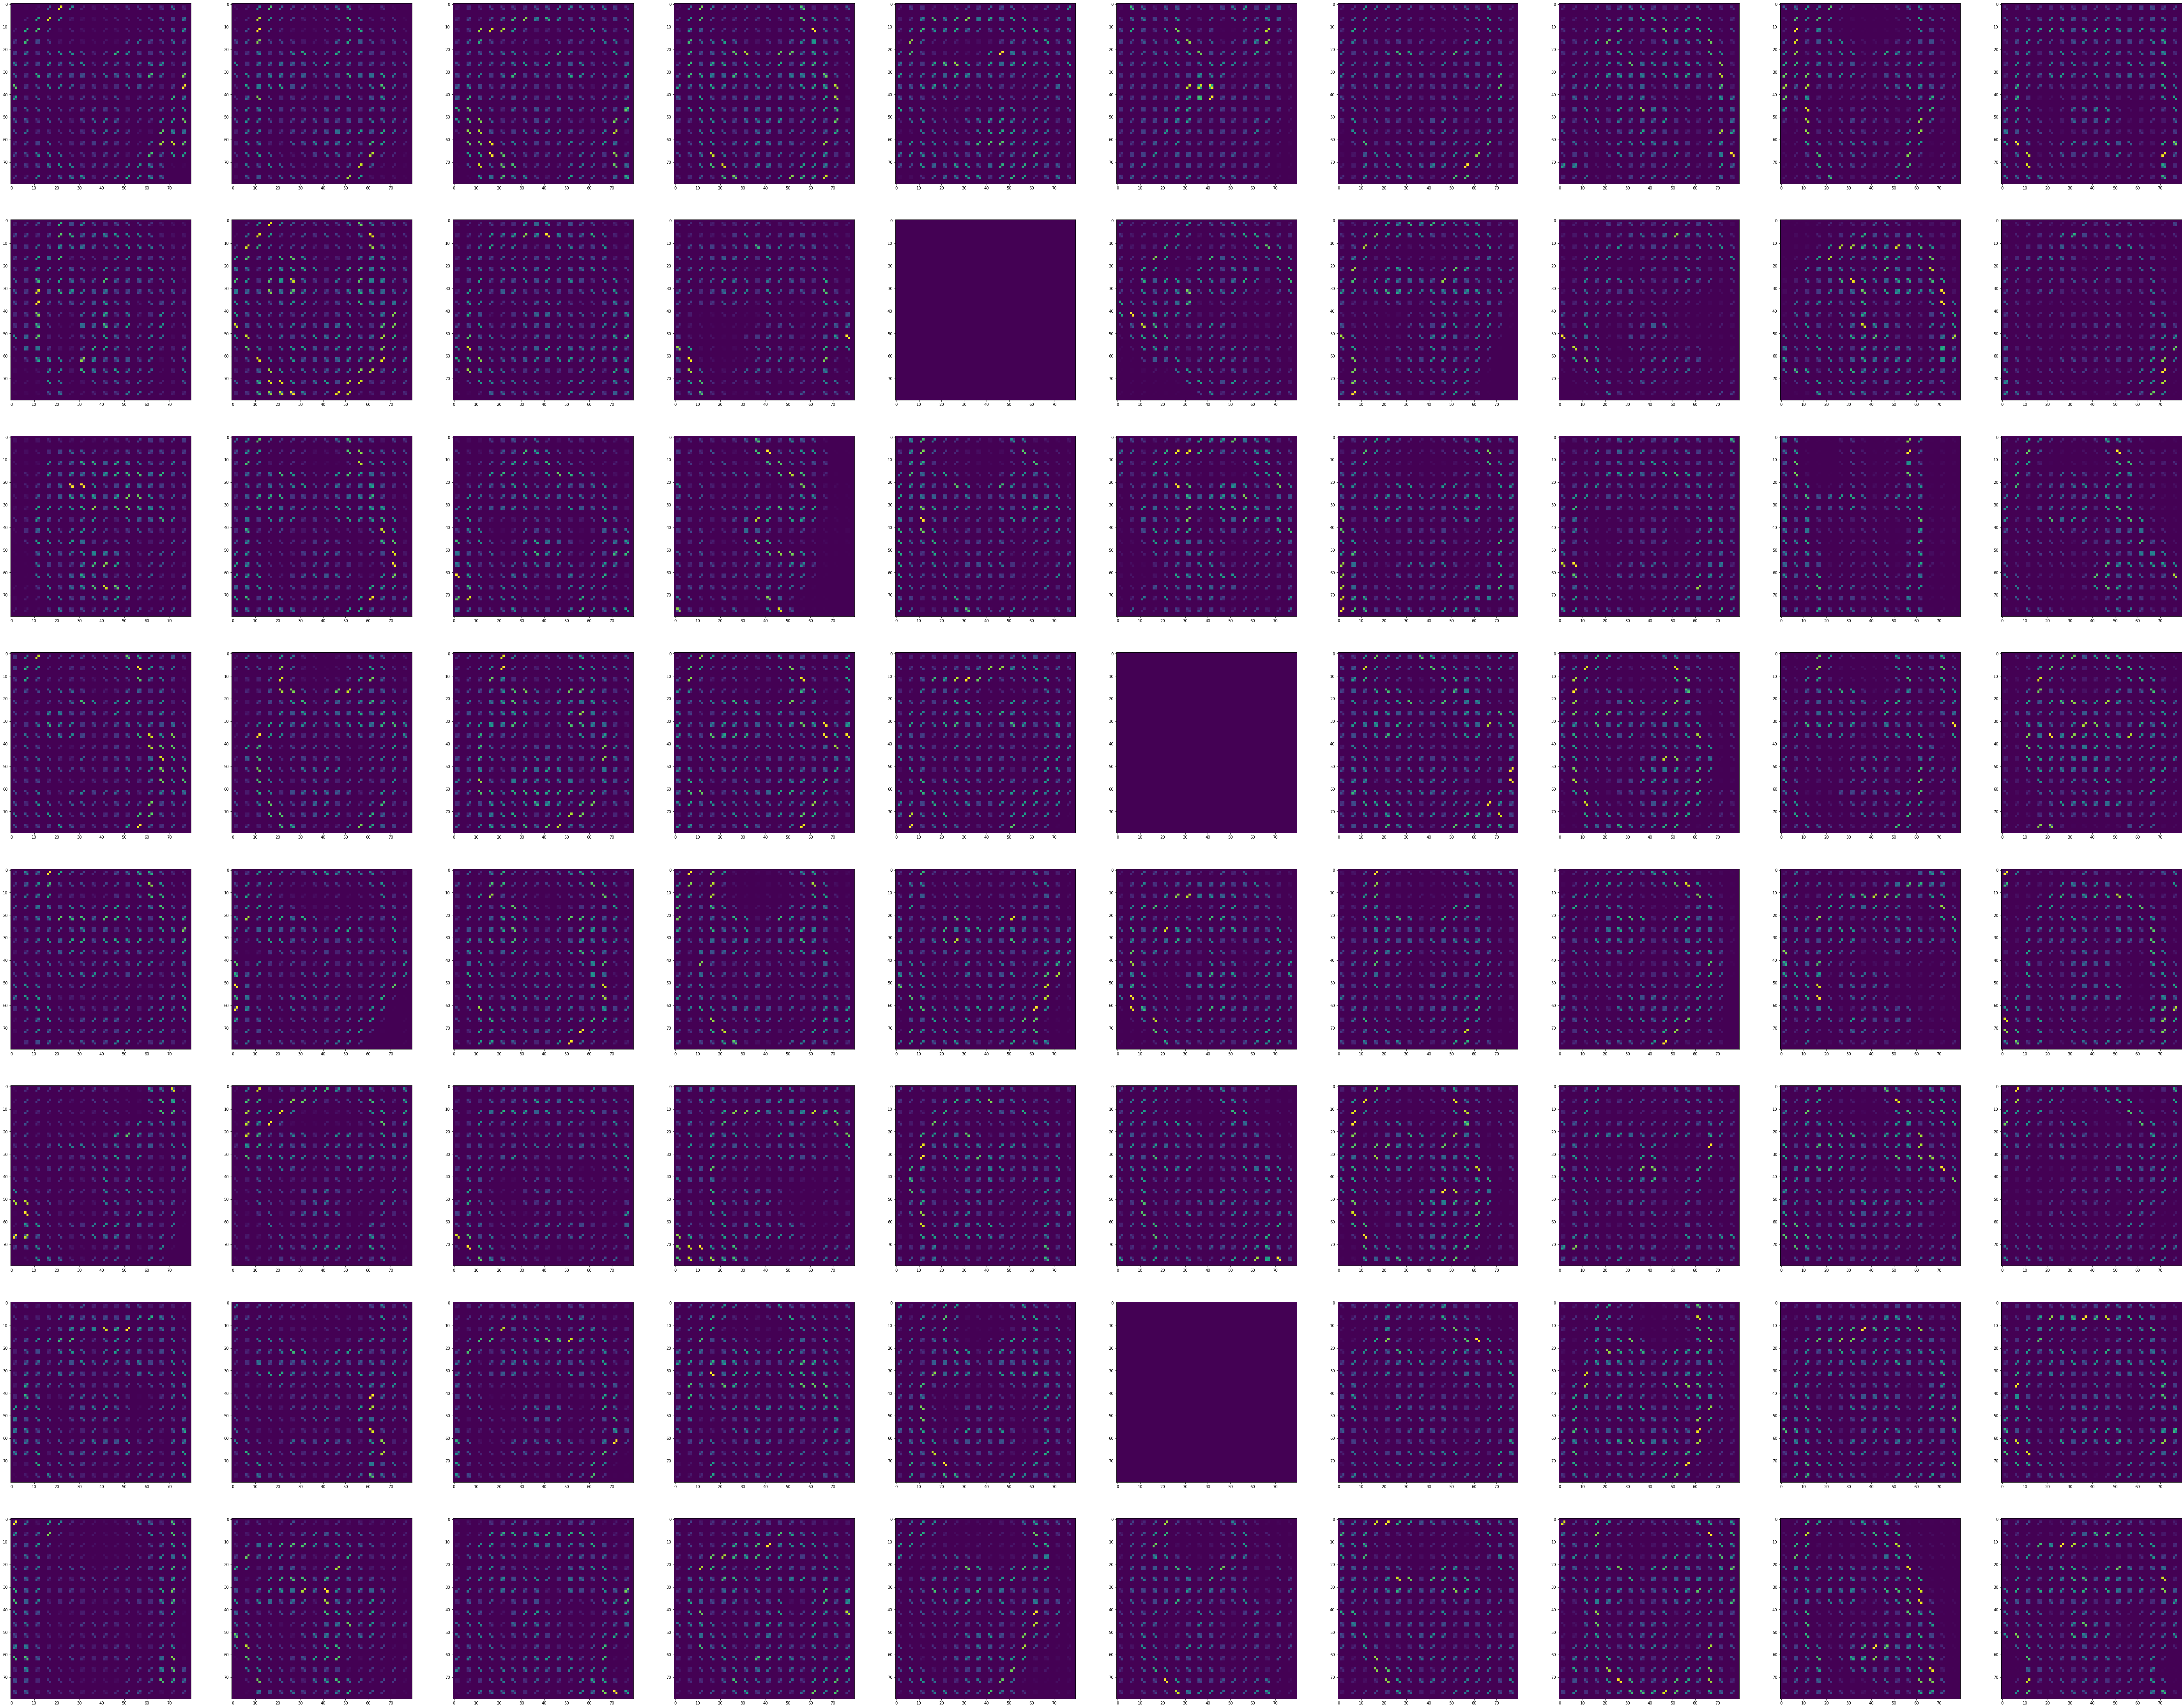

In [27]:
hog_model = HOGFeatureExtractor(train_X)

# Save the extracted data to /kaggle/working
hog_model.save_extract()

# plot the extracted data as hog
hog_model.plot_extract()

### 1.1.1. t-SNE Plots
t-Distributed Stochastic Neighbor Embedding (t-SNE) is a probabilistic, unsupervised, non-lineair technique used for data exploration to visualize higher dimensional data. It gives an intuitition on how the data is arranges in highter dimensions. This technique is relatively recent (2008), while PCA dates from 1933. The working is as follows: t-SNE tries to measure similarities between points in the high dimensional space and thereby uses a second set of probabilities, by using a student t-distribution. So finally, a gradient descend minimizes the cost function/diverence between the two distributions by measuring the pairwase similarities of low-dimensional points distribution and the distribution of input objects.

More technically explained, given N points -  $x_1,x_2,…,x_N$ in any dimension, t-SNE will compute the probability  $p_{i,j}$,  the probability of similarity of  $x_i$  and  $x_j$. In practice, given a cluster of N points, t-SNE will be a help in finding clusters with similarities in data points.

The parameters of a t-SNE are also optimisable. If the learning rate would be too high, the data will look lik a ball for example, with equispaced nearest neighbours. The parameters we finally have chosen, give a good picture on how seperable the data is.

In [28]:
## Convert ImageData to a 2D matrix 
def set2Matrix(X):
    nb_train_images = len(X)
    size = FACE_SIZE[0]*FACE_SIZE[1]

    M = np.array(np.zeros([nb_train_images, size]))
    for n in range(nb_train_images):
        Im = X[n]
        A = np.asarray(Im).reshape(-1)
        M[n,:] = A
    return M

C:\Users\Pili\.julia\conda\3\envs\CV\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


[t-SNE] Computing 79 nearest neighbors...
[t-SNE] Indexed 80 samples in 0.001s...
[t-SNE] Computed neighbors for 80 samples in 0.019s...
[t-SNE] Computed conditional probabilities for sample 80 / 80
[t-SNE] Mean sigma: 119.389334
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.439880
[t-SNE] KL divergence after 1000 iterations: 0.339497


[Text(0.5, 1.0, 't-SNE plot')]

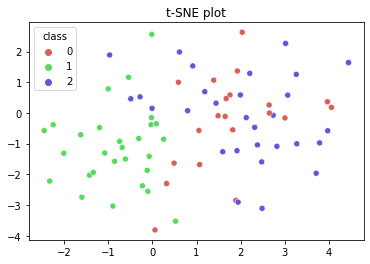

In [29]:
df = hog_model.save_extract()

M_hog = set2Matrix(df)


tsne = TSNE(n_components=2, verbose=1, perplexity=30.0, learning_rate=100, n_iter=1000)

tsne_results = tsne.fit_transform(M_hog)

TSNE1 = tsne_results[:,0].tolist()
TSNE2 = tsne_results[:,1].tolist()


sns.scatterplot(x=TSNE1, y=TSNE2, hue=train['class'], palette=sns.color_palette("hls", 3), data=M_hog, legend="full").set(title='t-SNE plot')


### 1.1.2. Discussion
#### a) How to make your descriptor behave well in different circumstances (e.g. image with different lighting)?
By simply **normalizing** the images with a 'L2' parameter, we **avoid brightness, contrast or other illumination effects**. This was done by adding `block_norm= ‘L2’` as a parameter of the HOG feature extractor. We could also have used L1 and L2-Hys as volunteering parameters. L2-Hys is sometimes used to reduce noise with the help of a L2-norm.


#### b) Visualize Feature Representation: [TODO]
t-SNE : This method classifies the images into clusters with similarities. Given N points -  $x_1,x_2,…,x_N$ in any dimension, t-SNE will compute the probability  pi,
j  the probability of similarity of  $x_i$  and  $x_j$ . The similarity is calculated based on the t-distribution. 
In practice given a cluster of N points t-SNE helps in finding clusters in which there exists similarity in the data points.

The parameters for t-SNE are number of components =2, perplexity=40 which governs the number of nearest neighbours, learning rate=200, if this is too high the data will look like a ball with equispaced nearest neighbours.     
number of iterations for optimization = 300. We also chose verbose = 1. The other various parameters were chosen to be default namely early_exaggeration, n_iter_without_progress, min_grad_norm,random_state=None, method='barnes_hut'.


#### c) How does this feature compare to your previous grabbing task in the individual assignment?
The HOG feature extractor is a gradient based method and is generally known as a more robust method than the one we used in the individual assignment. In the individual assignment, the object grabbing was based on a **threshold of a particular colour**. The HOG feature extractor in contrary, uses the **magnitude and slope** to compute features. It is computed by dividing an entire image into smaller cells an summing up their gradients over every pixel within each cell in an image.


#### d) Did you need specific pre-processing steps before computing these feature descriptors on your images (which ones and why)?
First of all, we convert the images to a **grayscale** as a basement for the following steps. Then, before processing, the images have been **resized**. In the paper of Dalal and Triggs, dimensions 128x64 were advised. However, the size depends on the application. In the notebook, the images were already resized to 100x100 pixels. We tried to resize the images to 80x80, bit it gave worser results on the t-sne, so we kept te original proposed size. This was all done in the HAARpreprocessing phase.
Further, we **normalized** the images with a 'L2' parameter, **to avoid brightness, contrast or other illumination effects**. Other possible paramaters we could have used are L1 and L2-Hys. Finally, in order to take a few neighboring pixels into account instead of single pixel values as its true value, we performed a **Gaussian filtering**.

#### e) Did the visualisation show good discriminative and robustness properties? [TODO]
Yes the t-SNE is able to show 3 major clusters of Jesse, Mila and the look alike. The HOG is able to show the major features of a face like nose, boundary, eyes etc. This is only possible for 
images with distinct values in pixels. For the black images which are outliers this is not possible.


#### f) Discussing missing values

In class 1 and 2, several black images appear. This means that the black images only contain 0 values, thus no information. Consequently, we can remove those images since they do not help our algorithm in classifying the faces correctly. 

Thereby, a few images which do not contain a face, are added to the training set.
In statistics, it is advised noy to throw away outliers unless we surely know that they are measurement errors. This is why we decided to keep these images in our dataset. Thereby, they can probably help us not to overfit certain parameters of a face. 

## 1.2. Baseline 2: PCA feature extractor
...

In [30]:
#Preprocess images and convert Images to 2D matrix
def PreprocessPCA(X):
    n = X.shape[0]
    size = FACE_SIZE[0]*FACE_SIZE[1]
    M = np.zeros([n,size])
    for i in range(n):
        img = X[i]
        converted = np.float32(img)
        gray = cv2.cvtColor(converted, cv2.COLOR_BGR2GRAY) #Convert to Grayscale image
        blur = cv2.GaussianBlur(gray,(5,5),cv2.BORDER_DEFAULT) # Gaussian Filtering
        A = np.asarray(blur).reshape(-1)
        M[i,:] = A
    #Mean substraction
    M = M - M.mean(axis=1).reshape(M.shape[0], -1)
    return M

In [31]:
#Visualisation of images form a 2D datamatrix
def plot_MatrixAsImages(title, images, n_col=3, n_row=5, cmap=plt.cm.gray):
    plt.figure(figsize=(2.0 * n_col, 2.26 * n_row))
    plt.suptitle(title, size=16)
    for i, comp in enumerate(images):
        plt.subplot(n_row, n_col, i + 1)
        vmax = max(comp.max(), -comp.min())
        plt.imshow(
            comp.reshape(FACE_SIZE),
            cmap=cmap,
            interpolation="nearest",
            vmin=-vmax,
            vmax=vmax,
        )
        plt.xticks(())
        plt.yticks(())
    plt.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.0)

In [32]:
# from sklearn.decomposition import PCA
class PCAFeatureExtractor(IdentityFeatureExtractor):
    """TODO: this feature extractor is under construction"""
    
    def __init__(self, n_components):
        self.n_components = n_components
        self.estimator = PCA(n_components=self.n_components, svd_solver="randomized", whiten=True)
        
    def fit(self,X):
        self.estimator.fit(X)
        components = self.estimator.components_
        return components
        
    def transform(self, X):
        Xc = self.estimator.transform(X)
        return Xc
        

    def inverse_transform(self, X):
        Xc = self.estimator.inverse_transform(X)
        return Xc

### 1.2.1. Eigenface Plots
...

In [33]:
## Convert images to 2D matrix with preprocessing
M_pca = PreprocessPCA(train_X)

Nb of components for 90.0 % of variance: 23


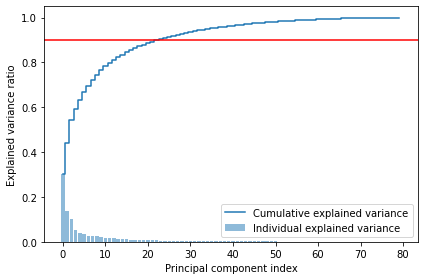

In [34]:
#Nb non-zero singular values: 80% -> 6 components
PCA_N = PCAFeatureExtractor(M_pca.shape[0])
comp = PCA_N.fit(M_pca)
exp_var_pca = PCA_N.estimator.explained_variance_ratio_
cum_sum_eigenvalues = np.cumsum(exp_var_pca)

perc = 0.9
N = [ n for n,i in enumerate(cum_sum_eigenvalues) if i>perc ][0]
print('Nb of components for',perc*100,'% of variance:',N)

plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.axhline(y=perc, color='r', linestyle='-')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

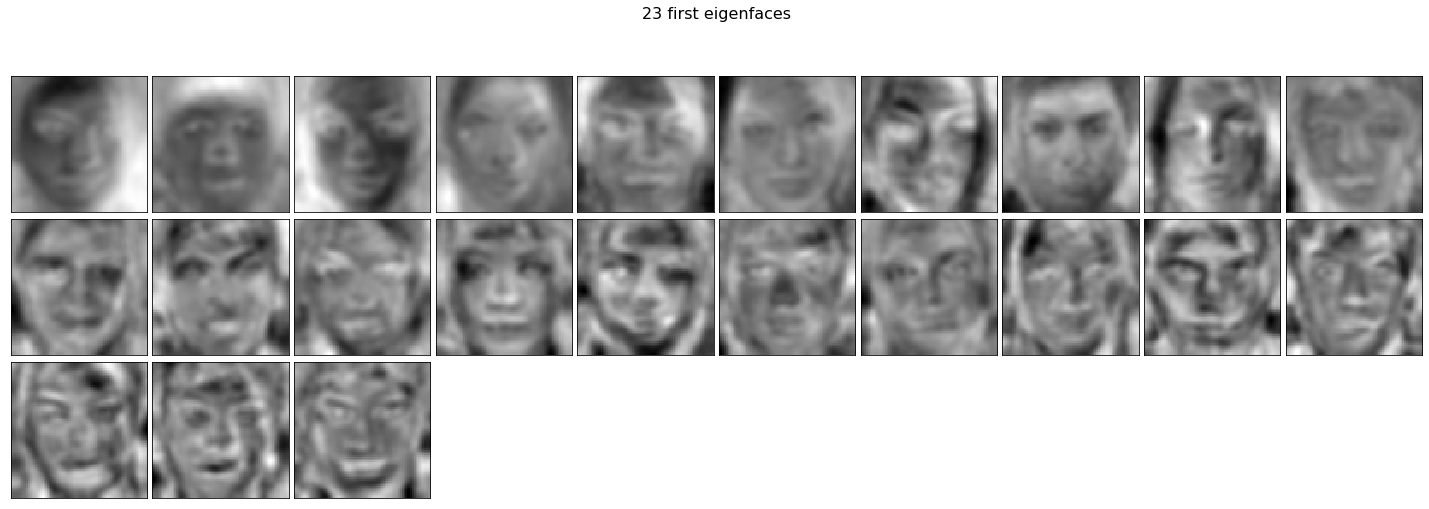

In [35]:
PCA_Ncomp = PCAFeatureExtractor(N)
Ncomp = PCA_Ncomp.fit(M_pca)
Title = str(N)+' first eigenfaces' 
plot_MatrixAsImages(Title , Ncomp,10,8)
plt.show()

### 1.2.2. Feature Space Plots
...

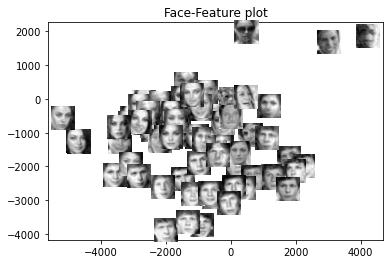

In [36]:
X_N = PCA_Ncomp.transform(M_pca)
Reconstruction = PCA_Ncomp.inverse_transform(X_N)
Y = np.matmul(M_pca, Ncomp[:2,:].T)


##Plot projected faces on the N-components on the feacture space
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
fig = plt.figure()
axes = fig.add_subplot(111)
plt.title("Face-Feature plot")
axes.scatter(Y[:,0],Y[:,1])
for i in range(M_pca.shape[0]):
    im = OffsetImage(Reconstruction[i,:].reshape(FACE_SIZE),zoom=0.3,cmap=plt.cm.gray)
    ab = AnnotationBbox(im, (Y[i,0],Y[i,1]), frameon=False)
    axes.add_artist(ab)

### 1.2.3. Discussion
...

In [ ]:
##Reconstruction

for i in range(1,81):
    PCA_recon = PCAFeatureExtractor(i)
    compR = PCA_recon.fit(M_pca)
    X_R = PCA_recon.transform(M_pca)
    Reconstruction = PCA_recon.inverse_transform(X_R)
    #Plot resinstruction of the 10th image
    clear_output(wait=True)
    plt.imshow(Reconstruction[10,:].reshape(100,100),cmap=plt.cm.gray)
    Title = "Reconstruction with "+str(i)+" eigenfaces"
    plt.title(Title)
    plt.show()
    time.sleep(0.5)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\Pili\.julia\conda\3\envs\CV\lib\site-packages\IPython\core\interactiveshell.py", line 3457, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\Pili\AppData\Local\Temp/ipykernel_4080/1755680949.py", line 10, in <module>
    plt.imshow(Reconstruction[10,:].reshape(100,100),cmap=plt.cm.gray)
ValueError: cannot reshape array of size 6400 into shape (100,100)

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\Pili\.julia\conda\3\envs\CV\lib\site-packages\IPython\core\interactiveshell.py", line 2077, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'ValueError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\Pili\.julia\conda\3\envs\CV\lib\site-packages\IPython\core\ultratb.py", line 1101, in get_recor

# 2. Evaluation Metrics
## 2.0. Example: Accuracy
As example metric we take the accuracy. Informally, accuracy is the proportion of correct predictions over the total amount of predictions. It is used a lot in classification but it certainly has its disadvantages...

In [37]:
from sklearn.metrics import accuracy_score

# 3. Classifiers
## 3.0. Example: The *'not so smart'* classifier
This random classifier is not very complicated. It makes predictions at random, based on the distribution obseved in the training set. **It thus assumes** that the class labels of the test set will be distributed similarly to the training set.

In [38]:
class RandomClassificationModel:
    """Random classifier, draws a random sample based on class distribution observed 
    during training."""
    
    def fit(self, X, y):
        """Adjusts the class ratio instance variable to the one observed in y. 

        Parameters
        ----------
        X : tensor
            Training set
        y : array
            Training set labels

        Returns
        -------
        self : RandomClassificationModel
        """
        
        self.classes, self.class_ratio = np.unique(y, return_counts=True)
        self.class_ratio = self.class_ratio / self.class_ratio.sum()
        return self
        
    def predict(self, X):
        """Samples labels for the input data. 

        Parameters
        ----------
        X : tensor
            dataset
            
        Returns
        -------
        y_star : array
            'Predicted' labels
        """

        np.random.seed(0)
        return np.random.choice(self.classes, size = X.shape[0], p=self.class_ratio)
    
    def __call__(self, X):
        return self.predict(X)
    

ERROR! Session/line number was not unique in database. History logging moved to new session 176


## 3.1. Baseline 1: My favorite classifier
For each feature we tested multiple classifiers. The models which had the best results where the 'support vector machine' and the 'logistic regression' model. Both models got a score around 0.72 for the test set when used on the HOG feature representation. 

The model of each classifier is build by first transforming the input data to one of the feature representations. Then the building process for both feature representations is the same. First the model is trained on the trainingsdata by the function <model>.fit(). Then using this new fitted model, we can start classifiying the test data with the function <model>.predict().

In [39]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

In [40]:
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier


class FavoriteClassificationModel():
    """TODO: this classifier is under construction."""
    def __init__(self,name):
        self.name=name
        if self.name == "SVM": #Support Vector Machine
            self.model = svm.SVC(kernel='linear', gamma='auto')
            
        elif self.name == "DT": #Decision Tree
            self.model = DecisionTreeClassifier()
            
        elif self.name == "LR": #Logistic regression
            self.model = LogisticRegression(random_state=0, max_iter=1000)
            
        elif self.name == "LR_OR": #Logistic regression One VS Rest
            LR = LogisticRegression()
            self.model = OneVsRestClassifier(LR)
         
        elif self.name == "Perceptron": #Perceptron
            self.model = Perceptron(tol=1e-3, random_state=0)
        
        elif self.name == "RC": #Ridge Classifier
            self.model =RidgeClassifier()
            
        elif self.name == "kNN": #k neighbors
            self.model = KNeighborsClassifier(leaf_size=1, p=2, n_neighbors=1)
            
        elif self.name == "RF": #Random Forest
            self.model = RandomForestClassifier(max_depth=2, random_state=0)
            
        else:
            print('No such a classifier')
        
    def fit(self, X, y):
         self.model.fit(X, y)
#         raise NotImplmentedError
        
    def predict(self, X):
        return self.model.predict(X)
#         raise NotImplmentedError

This cell below is a first test with the support vector machine on the trainingsdata with the HOG feature representation. First an test is done on only the images of Jesse and Mila. This results a score of 0.83. Then the same experiment is done but this time on all the trainingsdata (thus also the images of Michael and Sarah). The score when using all the trainingsdata is not as good. It has a score of 0.75. This is not suprising, since the faces of Michael and Sarah are similar to the ones of Jesse and Mila. This result was also already seen in the t-SNE plot above. There the blue and green dots (of Jesse and Mila) where mostly in disjunct clusters, whereas the red dots (of Michael and Sarah) where scattered through the plane, meaning the images of class zero are more difficult to distinguish.

In [41]:
# comparison scores on training set between prediction of only Mila/Jesse and prediction with also the look-a-likes

from sklearn.model_selection import train_test_split

train_y_ones = np.repeat(1, 30)
train_y_twos = np.repeat(2, 30)
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(train_X[train_y == 1], train_y_ones, test_size=0.2, random_state=0)
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(train_X[train_y == 2], train_y_twos, test_size=0.2, random_state=0)
X_train = np.append(X_train_1, X_train_2, axis = 0)
y_train = np.append(y_train_1, y_train_2)
X_test = np.append(X_test_1, X_test_2, axis = 0)
y_test = np.append(y_test_1, y_test_2)

# show how it looks like
print('Train set:', X_train.shape)
print('Test set:', X_test.shape)

# HOG
feature_extractor_train = HOGFeatureExtractor(X_train)
feature_extractor_test = HOGFeatureExtractor(X_test)

hog_train = feature_extractor_train.save_extract()
hog_test = feature_extractor_test.save_extract()


# TRANSFORM TRAIN SET
M_hog_train = set2Matrix(hog_train)

# TRANSFORM TEST SET
M_hog_test = set2Matrix(hog_test)

# Testing performance on only Jesse/Mila
SVM_model = FavoriteClassificationModel("SVM")
SVM_model.fit(M_hog_train, y_train)
SVM_predict = SVM_model.predict(M_hog_test)
#SVM_score = SVM_model.score(M_hog_test, y_test)
print('score of SVM on only Jesse/Mila images: ' , accuracy_score(y_test, SVM_predict))

# Testing performance on also the look alikes
X_train, X_test, y_train, y_test = train_test_split(train_X, train_y, test_size=0.2, random_state=0)

# HOG
feature_extractor_train = HOGFeatureExtractor(X_train)
feature_extractor_test = HOGFeatureExtractor(X_test)

hog_train = feature_extractor_train.save_extract()
hog_test = feature_extractor_test.save_extract()


# TRANSFORM TRAIN SET
M_hog_train = set2Matrix(hog_train)

# TRANSFORM TEST SET
M_hog_test = set2Matrix(hog_test)

# Testing performance on only Jesse/Mila
SVM_model = FavoriteClassificationModel("SVM")
SVM_model.fit(M_hog_train, y_train)
SVM_predict = SVM_model.predict(M_hog_test)
#SVM_score = SVM_model.score(M_hog_test, y_test)
print('score of SVM on all images: ' , accuracy_score(y_test, SVM_predict))

Train set: (48, 80, 80, 3)
Test set: (12, 80, 80, 3)
score of SVM on only Jesse/Mila images:  0.8333333333333334
score of SVM on all images:  0.75


# 4. Experiments
<div class="alert alert-block alert-info"> <b>NOTE:</b> Do <i>NOT</i> use this section to keep track of every little change you make in your code! Instead, highlight the most important findings and the major (best) pipelines that you've discovered.  
</div>
<br>

## 4.0. Example: basic pipeline
The basic pipeline takes any input and samples a label based on the class label distribution of the training set. As expected the performance is very poor, predicting approximately 1/4 correctly on the training set. There is a lot of room for improvement but this is left to you ;). 

In [42]:
# HOG

# We are training on all the data.
feature_extractor_train = HOGFeatureExtractor(train_X)
feature_extractor_test = HOGFeatureExtractor(test_X)

hog_train = feature_extractor_train.save_extract()
hog_test = feature_extractor_test.save_extract()


# TRANSFORM TRAIN SET
M_hog_train = set2Matrix(hog_train)

# TRANSFORM TEST SET
M_hog_test = set2Matrix(hog_test)


In [43]:
# PCA
# convert original data to the features

# TRANSFORM TRAIN SET
Train = PreprocessPCA(train_X)
PCA_FE = PCAFeatureExtractor(N)
comp = PCA_FE.fit(Train)
M_pca_train = PCA_FE.transform(Train)
# TRANSFORM TEST SET
Test = PreprocessPCA(test_X)
M_pca_test = PCA_FE.transform(Test)

In [44]:
# DT Hog
DT_model = FavoriteClassificationModel("DT")
DT_model.fit(M_hog_train, train_y)
DT_predict = DT_model.predict(M_hog_test)

In [45]:
# LR Hog
LR_model = FavoriteClassificationModel("LR")
LR_model.fit(M_hog_train, train_y)
LR_predict = LR_model.predict(M_hog_test)

In [46]:
# SVM Hog
SVM_model = FavoriteClassificationModel("SVM")
SVM_model.fit(M_hog_train, train_y)
SVM_predict = SVM_model.predict(M_hog_test)

In [47]:
# Perceptron Hog
PE_model = FavoriteClassificationModel("Perceptron")
PE_model.fit(M_hog_train, train_y)
PE_predict = PE_model.predict(M_hog_test)

In [48]:
# RC Hog
RC_model = FavoriteClassificationModel("RC")
RC_model.fit(M_hog_train, train_y)
RC_predict = RC_model.predict(M_hog_test)

In [49]:
# kNN Hog
neigh_model = FavoriteClassificationModel("kNN")
neigh_model.fit(M_hog_train, train_y)
neigh_predict = neigh_model.predict(M_hog_test)

In [50]:
# RF Hog
RF_model = FavoriteClassificationModel("RF")
RF_model.fit(M_hog_train, train_y)
RF_predict = RF_model.predict(M_hog_test)

In [51]:
# LR ONEVSREST PCA
LR_model_PCA = FavoriteClassificationModel("LR_OR")
LR_model_PCA.fit(M_pca_train, train_y)
LR_predict_pca = LR_model_PCA.predict(M_pca_test)

Check how many from each class

In [52]:
Ty = DT_predict.copy()
print(Ty[Ty==0].shape)
print(Ty[Ty==1].shape)
print(Ty[Ty==2].shape)

(627,)
(553,)
(636,)


In [53]:
Ty = SVM_predict.copy()
print(Ty[Ty==0].shape)
print(Ty[Ty==1].shape)
print(Ty[Ty==2].shape)

(746,)
(551,)
(519,)


In [54]:
Ty = neigh_predict.copy()
print(Ty[Ty==0].shape)
print(Ty[Ty==1].shape)
print(Ty[Ty==2].shape)

(774,)
(670,)
(372,)


In [55]:
Ty = LR_predict.copy()
print(Ty[Ty==0].shape)
print(Ty[Ty==1].shape)
print(Ty[Ty==2].shape)

(675,)
(597,)
(544,)


In [56]:
Ty = PE_predict.copy()
print(Ty[Ty==0].shape)
print(Ty[Ty==1].shape)
print(Ty[Ty==2].shape)

(748,)
(546,)
(522,)


In [57]:
Ty = RC_predict.copy()
print(Ty[Ty==0].shape)
print(Ty[Ty==1].shape)
print(Ty[Ty==2].shape)

(679,)
(634,)
(503,)


In [58]:
Ty = RF_predict.copy()
print(Ty[Ty==0].shape)
print(Ty[Ty==1].shape)
print(Ty[Ty==2].shape)

(25,)
(728,)
(1063,)


In [59]:
Ty = LR_predict_pca.copy()
print(Ty[Ty==0].shape)
print(Ty[Ty==1].shape)
print(Ty[Ty==2].shape)
##Score 0.61894

(451,)
(666,)
(699,)


In [60]:
# evaluate performance of the model on the training set
#train_y_star = model(train_X)

#train_y_star = model(X_train)
#train_y_star = model(M_hog_train)

#model(X_train)

#"The performance on the training set is {:.2f}. This however, does not tell us much about the actual performance (generalisability).".format(
#    accuracy_score(train_y, train_y_star))

In [61]:
# predict the labels for the test set 
#test_y_star = model(X_test)
test_y_star = LR_predict

print(test_y_star)

[1 0 0 ... 1 0 0]


In [62]:
test_y_star = SVM_predict

print(test_y_star)

[1 0 0 ... 1 0 0]


In [63]:
test_y_star = neigh_predict

print(test_y_star)

[1 2 0 ... 1 0 0]


In [64]:
test_y_star = LR_predict

print(test_y_star)

[1 0 0 ... 1 0 0]


In [65]:
test_y_star = PE_predict

print(test_y_star)

[1 0 0 ... 1 2 0]


In [66]:
test_y_star = RC_predict

print(test_y_star)

[1 0 0 ... 1 0 0]


In [67]:
test_y_star = LR_predict_pca

print(test_y_star)

[1 2 0 ... 1 0 0]


## 4.1 Improvements

#### Transfer learning

As knew in general, neural networks take a lot of resources train. With transfer learning, we make use of a pre-trained model, freeze it, and add some more layers to it and then only learn the upper layers for a particular face recognition. Imagine we trained a neural network on 5000 faces. The only thing we do is use that model and add the 3 additional faces we want to recognize. The model is trained only on the additional layer to recognize new faces.

Transfer learning is a popular method used in face recognition. It is an optimisation to save time and get better a performance. Since it is used in the context of deep learning, the first intuition would say that we need a lot of data, and this is something that was not provided initially in the training set. Here comes data augmentation into play. It is a method to enlarge the dataset by performing several transformations on your input data (e.g. flip, rotate, translation, scale, crop, ...) . However, transfer learning will make it possible to give decent results with smaller datasets, while a deep neural network would not.

In [68]:
# TODO

#### Data augmentation + prior knowledge
As discussed previously, we can use our prior knowledge of the model to augment the data with virtual examples. As the class stay invariant under transformation of the input. We tried to make virtual examples by mirroring the given training examples which did not result in good scores. Furthermore we tried to augment the data with blurred copies of the original images, these virtual examples resulted in better scores. However, the best score was reached with no augmented data

In [69]:
# HOG on augmented data

# We are training on all the data.
feature_extractor_train_aug = HOGFeatureExtractor(newTrain_X)
feature_extractor_test = HOGFeatureExtractor(test_X)

hog_train_aug = feature_extractor_train_aug.save_extract()
hog_test = feature_extractor_test.save_extract()


# TRANSFORM TRAIN SET
M_hog_train_aug = set2Matrix(hog_train_aug)

# TRANSFORM TEST SET
M_hog_test = set2Matrix(hog_test)

In [70]:
# LR Hog on augmented data
LR_model = FavoriteClassificationModel("LR")
LR_model.fit(M_hog_train_aug, newTrain_y)
LR_predict = LR_model.predict(M_hog_test)

In [71]:
# SVM Hog augemented data
SVM_model = FavoriteClassificationModel("SVM")
SVM_model.fit(M_hog_train_aug, newTrain_y)
SVM_predict = SVM_model.predict(M_hog_test)

In [72]:
Ty = SVM_predict.copy()
print(Ty[Ty==0].shape)
print(Ty[Ty==1].shape)
print(Ty[Ty==2].shape)

(744,)
(542,)
(530,)


In [73]:
Ty = LR_predict.copy()
print(Ty[Ty==0].shape)
print(Ty[Ty==1].shape)
print(Ty[Ty==2].shape)

(667,)
(598,)
(551,)


In [74]:
test_y_star = LR_predict

print(test_y_star)

[1 0 0 ... 1 2 0]


In [75]:
test_y_star = SVM_predict

print(test_y_star)

[1 0 0 ... 1 0 0]


#### Loss function
Below, the loss function for the support vector machine is plotted. As can be seen on the plot, the MSE of the training set is really low. This is probably because there are too few examples to train from. Because there are so few examples the model can be overfitted. This means the model can perfectly fit the learned the example images, however it is not regularized. This results in the case where the model performs good on the training set, but far poorer on the test set. Therefore adding more data would probably result in better performance. 

Training scores:

 [[-0.       -0.       -0.       -0.       -0.      ]
 [-0.       -0.       -0.       -0.       -0.      ]
 [-0.       -0.       -0.       -0.       -0.      ]
 [-0.       -0.       -0.       -0.       -0.      ]
 [-0.015625 -0.015625 -0.015625 -0.015625 -0.      ]]

 ----------------------------------------------------------------------

Validation scores:

 [[-0.625  -1.375  -1.3125 -1.625  -0.875 ]
 [-0.625  -1.     -1.125  -1.625  -0.625 ]
 [-1.1875 -0.5625 -1.125  -1.25   -0.75  ]
 [-0.375  -0.8125 -0.625  -0.75   -1.    ]
 [-0.375  -0.625  -0.875  -0.75   -0.5   ]]

 ----------------------------------------------------------------------
Mean training scores

 6    -0.0000
20   -0.0000
35   -0.0000
49   -0.0000
64    0.0125
dtype: float64

 --------------------

Mean validation scores

 6     1.1625
20    1.0000
35    0.9750
49    0.7125
64    0.6250
dtype: float64


(-0.2, 2.0)

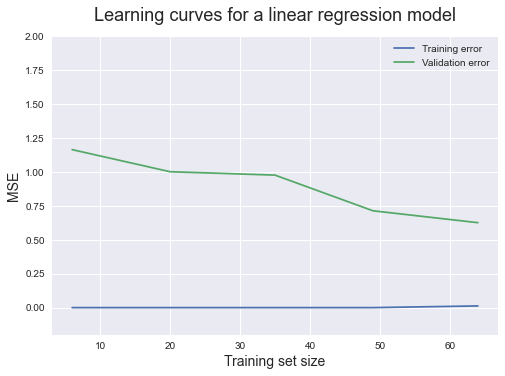

In [76]:
from sklearn.model_selection import learning_curve

train_sizes = [1, 20, 40, 60, 80]

train_sizes, train_scores, validation_scores = learning_curve(svm.SVC(kernel='linear', gamma='auto'), M_hog_train , train_y, scoring = 'neg_mean_squared_error')

print('Training scores:\n\n', train_scores)
print('\n', '-' * 70) # separator to make the output easy to read
print('\nValidation scores:\n\n', validation_scores)

train_scores_mean = -train_scores.mean(axis = 1)
validation_scores_mean = -validation_scores.mean(axis = 1)

print('\n', '-' * 70) # separator to make the output easy to read
print('Mean training scores\n\n', pd.Series(train_scores_mean, index = train_sizes))
print('\n', '-' * 20) # separator
print('\nMean validation scores\n\n',pd.Series(validation_scores_mean, index = train_sizes))

plt.style.use('seaborn')
plt.plot(train_sizes, train_scores_mean, label = 'Training error')
plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')
plt.ylabel('MSE', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for a linear regression model', fontsize = 18, y = 1.03)
plt.legend()
plt.ylim(-0.2,2)

The loss curve in case of more trzining examples is plotted below. The gap between the validation error and the training error did become smaller, so there's less variance. However there is still some room for improvement. Adding more data can decrease the gap further. 

Training scores:

 [[-0.         -0.         -0.         -0.         -0.        ]
 [-0.         -0.         -0.         -0.         -0.        ]
 [-0.01724138 -0.01724138 -0.         -0.         -0.        ]
 [-0.01219512 -0.01219512 -0.         -0.01219512 -0.01219512]
 [-0.00934579 -0.00934579 -0.         -0.00934579 -0.00934579]]

 ----------------------------------------------------------------------

Validation scores:

 [[-1.7037037  -0.66666667 -0.66666667 -0.74074074 -0.46153846]
 [-1.11111111 -1.11111111 -0.51851852 -0.37037037 -0.69230769]
 [-0.59259259 -1.25925926 -0.55555556 -0.2962963  -0.26923077]
 [-0.44444444 -1.11111111 -0.40740741 -0.14814815 -0.19230769]
 [-0.14814815 -0.33333333 -0.33333333 -0.14814815 -0.19230769]]

 ----------------------------------------------------------------------
Mean training scores

 10    -0.000000
34    -0.000000
58     0.006897
82     0.009756
107    0.007477
dtype: float64

 --------------------

Mean validation scores

 10     0.84786

(-0.2, 1.0)

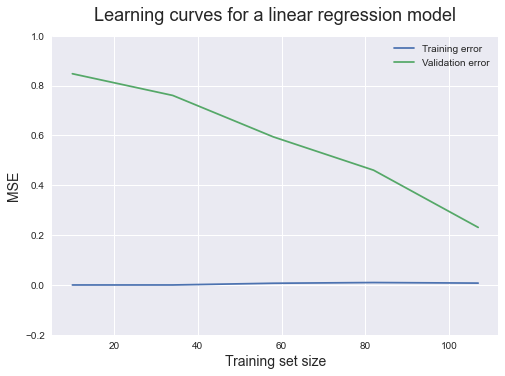

In [83]:
train_sizes, train_scores, validation_scores = learning_curve(svm.SVC(kernel='linear', gamma='auto'), M_hog_train_aug , newTrain_y, scoring = 'neg_mean_squared_error')

print('Training scores:\n\n', train_scores)
print('\n', '-' * 70) # separator to make the output easy to read
print('\nValidation scores:\n\n', validation_scores)

train_scores_mean = -train_scores.mean(axis = 1)
validation_scores_mean = -validation_scores.mean(axis = 1)

print('\n', '-' * 70) # separator to make the output easy to read
print('Mean training scores\n\n', pd.Series(train_scores_mean, index = train_sizes))
print('\n', '-' * 20) # separator
print('\nMean validation scores\n\n',pd.Series(validation_scores_mean, index = train_sizes))

plt.style.use('seaborn')
plt.plot(train_sizes, train_scores_mean, label = 'Training error')
plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')
plt.ylabel('MSE', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for a linear regression model', fontsize = 18, y = 1.03)
plt.legend()
plt.ylim(-0.2,1)

# 5. Publishing best results

In [78]:
submission = test.copy().drop('img', axis = 1)
submission['class'] = test_y_star

submission

class
id         
0         1
1         0
2         0
3         1
4         1
...     ...
1811      1
1812      0
1813      1
1814      0
1815      0

[1816 rows x 1 columns]

In [79]:
submission.to_csv('submission_LR_HOG_Augmented.csv')


# 6. Discussion
...

In summary we contributed the following: 
* 
